In [1]:
# Imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
sys.path.append('src/')

In [2]:
# Set a consistent style for the plots
sns.set_theme(style="whitegrid")

In [3]:
# Prefix path
PREFIX_PATH = 'data'

### Movie Metadata

In [4]:
# Set to display all columns
pd.set_option('display.max_columns', None)

# Set to display 50 rows 
pd.set_option('display.max_rows', 50)

# Importing the movie dataset
movie = pd.read_csv(f'{PREFIX_PATH}/MovieSummaries/movie.metadata.tsv', sep= '\t', header=None)

# Define the columns extracted from the data README.md file
movie.columns = ['WikiID', 'FreebaseID', 'Name', 'ReleaseDate',
                     'Revenue', 'Runtime', 'Languages_tuple', 'Countries_tuples', 'Genres_tuples']
movie.head()

,WikiID,FreebaseID,Name,ReleaseDate,Revenue,Runtime,Languages_tuple,Countries_tuples,Genres_tuples
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


#### Lets look at the number of rows and columns in the movie data as well as the datatypes

In [5]:
print(movie.shape)
print(movie.dtypes)

(81741, 9)
WikiID                int64
FreebaseID           object
Name                 object
ReleaseDate          object
Revenue             float64
Runtime             float64
Languages_tuple      object
Countries_tuples     object
Genres_tuples        object
dtype: object


#### Checking missing values in the movie dataset

In [6]:
# First check for the first 6 columns which can contain NaN values
print((pd.isna(movie.iloc[:,:6]).sum()) / len(movie))
# The last columns are dictionaries so look for empty dictionaries
print((movie.iloc[:, 6:] == '{}').sum() / len(movie))

WikiID         0.000000
FreebaseID     0.000000
Name           0.000000
ReleaseDate    0.084437
Revenue        0.897224
Runtime        0.250180
dtype: float64
Languages_tuple     0.169633
Countries_tuples    0.099754
Genres_tuples       0.028064
dtype: float64


It seems that revenue is missing almost all the time, but that is no problem because we don't use it anyway. To make the data easier to understand we will drop that column. Also the runtime has around 25% percent missing values, which is also no problem because we don't intend to use it. But we will keep it for now and replace the NaN values with the mean which is a common technique. The release date is nearly never missing and hard to fill in so we will keep the missing values for now and handle them during analysis. Fortunately the language, countrie and genre tuples also have only a very low amount of missing values because it is very hard to fill these missing values in a meaningful way. So we will leave the missing values in these attributes for now as well and handle them later in the analysis.

In [7]:
# Drop column revenue, ignore errors so if the column is already dropped no error occurs
movie = movie.drop(['Revenue'], axis=1,errors='ignore')
# Replace missing runtime values with the mean
mean_runtime = movie['Runtime'].mean()
movie['Runtime'] = movie['Runtime'].fillna(value=mean_runtime)
# Check result
print((pd.isna(movie.iloc[:,:6]).sum()) / len(movie))

WikiID             0.000000
FreebaseID         0.000000
Name               0.000000
ReleaseDate        0.084437
Runtime            0.000000
Languages_tuple    0.000000
dtype: float64


#### Parse the tuples into lists for easier handling later on

In [8]:
from utils.methods import conv_to_dict, get_list

In [9]:
# Add columns for each attribute which contains a dictionary and apply the helper function to convert it to a list
movie['Languages'] = movie['Languages_tuple'].apply(conv_to_dict).apply(get_list)
movie['Countries'] = movie['Countries_tuples'].apply(conv_to_dict).apply(get_list)
movie['Genres'] = movie['Genres_tuples'].apply(conv_to_dict).apply(get_list)

In [10]:
# Check result
movie.head()

,WikiID,FreebaseID,Name,ReleaseDate,Runtime,Languages_tuple,Countries_tuples,Genres_tuples,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[German Language],[Germany],[Drama]


---

### Plot Summary Data

In [11]:
# Import the plot summary data
plots = pd.read_csv(f'{PREFIX_PATH}/MovieSummaries/plot_summaries.txt', sep='\t', header=None)
plots.columns = ['WikiID', 'Plot']
plots.head()

,WikiID,Plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


#### Check NaN values and the dtype for the plot summaries

In [12]:
# Get NaN values
print((pd.isna(plots['Plot']).sum()) / len(plots['Plot']))

# Find dtypes of the plot summaries, use apply and value counts because dtype returns object which is not helpful
print(plots['Plot'].apply(type).value_counts())

0.0
<class 'str'>    42303
Name: Plot, dtype: int64


Fortunately there are no missing values in the plot summaries, and all plots are strings, so we don't need further processing here.

#### Plot summaries alone do not provide much value, we merge it with our cleaned movie metadata

We use a left join for all merging, because the movie metadata is the main dataset, if the other datasets can't be merged completely we don't want to lose datapoints for now, but have NaN values for these datapoints which are then handled later during the analysis, for example with grouping.

In [13]:
# Left join of plots on movie metadata
movie_plot = movie.merge(plots, on='WikiID', how='left')
movie_plot.head()

,WikiID,FreebaseID,Name,ReleaseDate,Runtime,Languages_tuple,Countries_tuples,Genres_tuples,Languages,Countries,Genres,Plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra..."


#### Let's delve deeper into the merged dataset

We add a column merge_year which only contains the year of the release date, as for our analysis the year is sufficient and there are datapoints where the release date only contains a year. Furthemore we can use this year later for merging external datasets, hence the name.

In [14]:
# Add the merge year
movie_plot['merge_year'] = movie_plot['ReleaseDate'].apply(lambda x: x.split('-')[0] if pd.notna(x) else None).astype('Int64')

#### Let's get a first overview of the distribution of the release year
This will be needed for time series analysis later on

<Axes: xlabel='merge_year', ylabel='Count'>

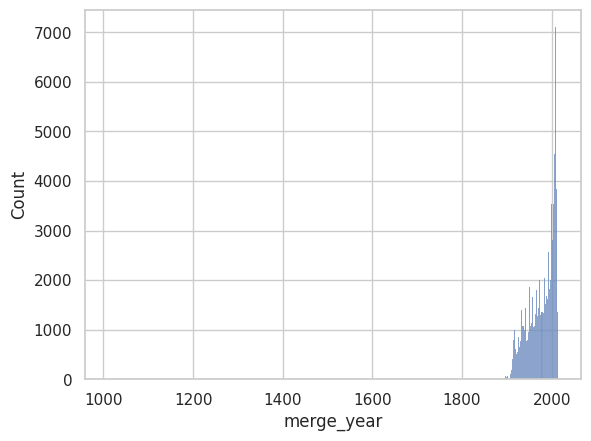

In [15]:
# Remove NA values for plotting

sns.histplot(x='merge_year', data=movie_plot)

#### There seems to be an outlier somewhere...

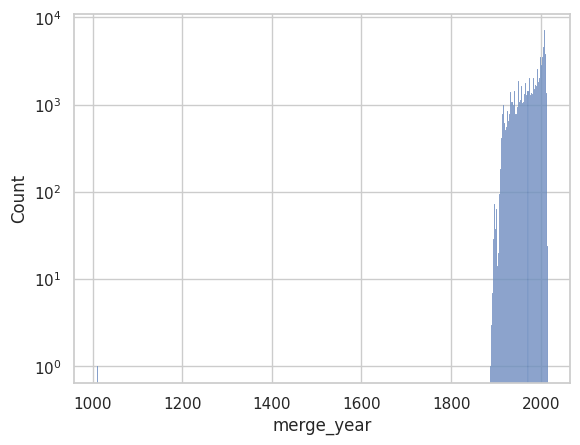

In [16]:
# Use log scale to detect outliers
hist = sns.histplot(x='merge_year', data=movie_plot)
hist.set_yscale('log')

In [17]:
# Find minimum year
movie_plot['merge_year'].min()

1010

#### Movie released in 1010 seems weird...

In [18]:
movie_plot[movie_plot['merge_year'] == 1010]

,WikiID,FreebaseID,Name,ReleaseDate,Runtime,Languages_tuple,Countries_tuples,Genres_tuples,Languages,Countries,Genres,Plot,merge_year
62836,29666067,/m/0fphzrf,Hunting Season,1010-12-02,140.0,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc...","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My...","[Turkish Language, English Language]",[Turkey],"[Crime Fiction, Mystery, Drama, Thriller]",Veteran homicide cop Ferman and his hot-heade...,1010


#### Hunting Season is a movie released in 2010, so must be a typo!

In [19]:
# Fix the year
movie_plot.loc[movie_plot['merge_year'] == 1010, 'merge_year'] = 2010
movie_plot.loc[movie_plot['ReleaseDate'] == '1010-12-02', 'ReleaseDate'] = '2010-12-02'
movie_plot[movie_plot['Name'] == 'Hunting Season']

,WikiID,FreebaseID,Name,ReleaseDate,Runtime,Languages_tuple,Countries_tuples,Genres_tuples,Languages,Countries,Genres,Plot,merge_year
62836,29666067,/m/0fphzrf,Hunting Season,2010-12-02,140.0,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc...","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My...","[Turkish Language, English Language]",[Turkey],"[Crime Fiction, Mystery, Drama, Thriller]",Veteran homicide cop Ferman and his hot-heade...,2010


#### Let's have a look at the languages included in our data

In [20]:
# Expand the languages and make a copy for further analysis
movie_languages_expanded = movie_plot.explode('Languages').reset_index(drop=True).copy()
movie_languages_expanded.shape

(95172, 13)

#### Let's see how the number of movies in the top 5 languages has evolved over time

In [21]:
# Filter for 5 most frequent languages
top_languages = movie_languages_expanded['Languages'].value_counts().nlargest(5).index
movie_languages_expanded['Languages'] = movie_languages_expanded['Languages'].apply(lambda x: x if x in top_languages else 'Other')

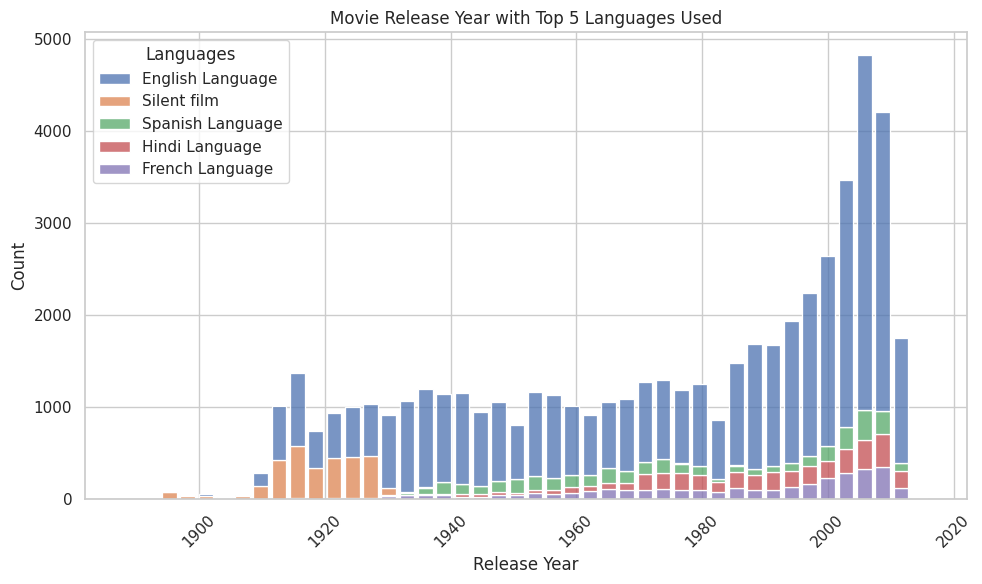

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(data=movie_languages_expanded[movie_languages_expanded['Languages'] != 'Other'], x='merge_year', hue='Languages', multiple='stack', shrink=0.8)
handles, labels = plt.gca().get_legend_handles_labels()

plt.title('Movie Release Year with Top 5 Languages Used')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Let's see how the number of movies in the top 5 genres has evolved over time

In [23]:
# Expand the genres and make a copy for further analysis
movie_genres_expanded = movie_plot.explode('Genres').reset_index(drop=True).copy()
movie_genres_expanded.shape

(245623, 13)

In [24]:
# Filter for 5 most frequent genres
top_genres = movie_genres_expanded['Genres'].value_counts().nlargest(5).index
movie_genres_expanded['Genres'] = movie_genres_expanded['Genres'].apply(lambda x: x if x in top_genres else 'Other')

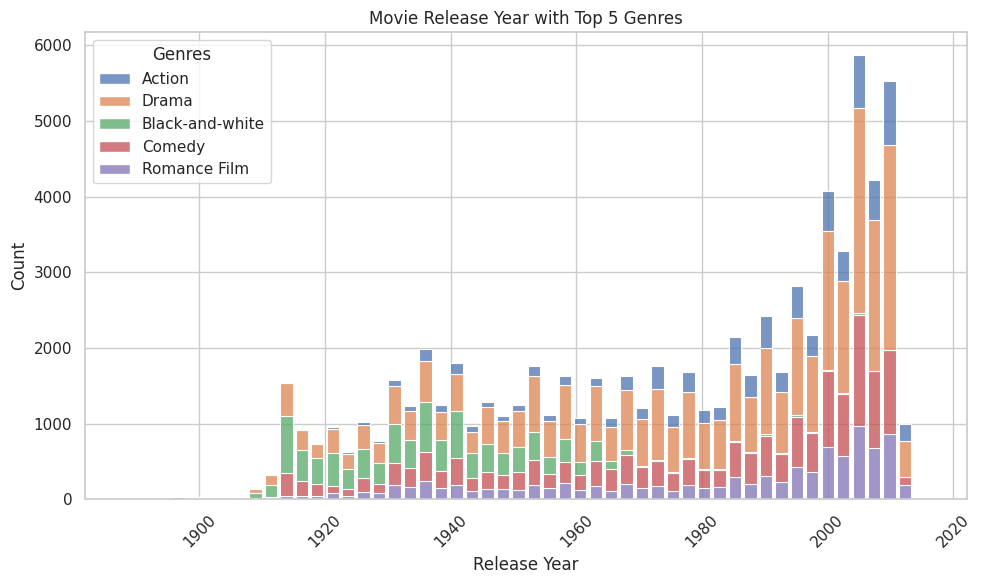

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(data=movie_genres_expanded[movie_genres_expanded['Genres'] != 'Other'], x='merge_year', hue='Genres', multiple='stack', shrink=0.8)
handles, labels = plt.gca().get_legend_handles_labels()

plt.title('Movie Release Year with Top 5 Genres')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

### Extract Emotions from Movie Plots

In the next step we will extract the emotional tone of a film from the movie plot summaries. Therefore we use NRCLex, a python package which extract emotions from a given text, as well as two pre-trained language models from hugging face. The implementations for the extraction can be found in the emotion.py file in the utils folder, we will only apply the functions here to enrich the data and perform some initial analyses.

References:
Crowdsourcing a Word-Emotion Association Lexicon, Saif Mohammad and Peter Turney, Computational Intelligence, 29 (3), 436-465, 2013

#### Let's look at the plot lengths and their distribution first

Plot length statistics:
count    42204.000000
mean      1783.583594
std       1808.491453
min         99.000000
25%        508.000000
50%       1079.000000
75%       2602.000000
max      28159.000000
Name: Plot, dtype: float64


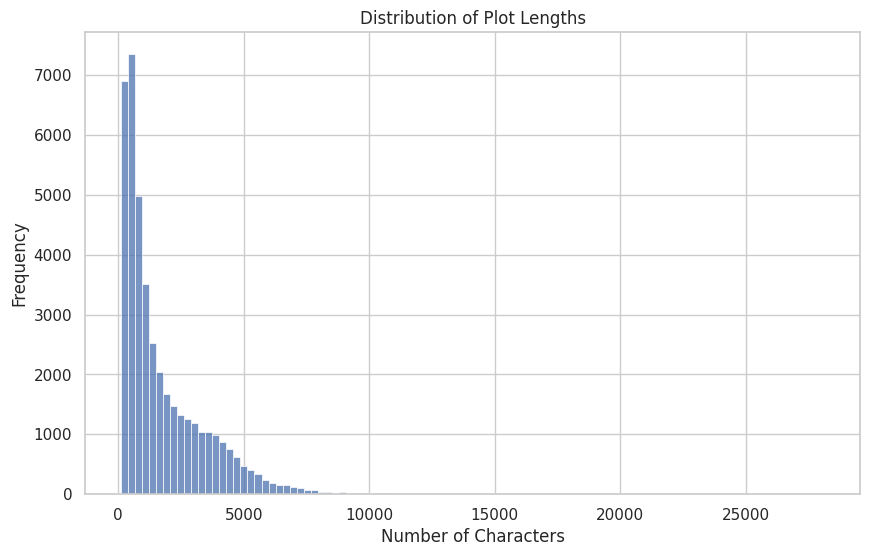

In [26]:
# Calculate plot lengths and show distribution
plot_lengths = movie_plot['Plot'].str.len().dropna()
print("Plot length statistics:")
print(plot_lengths.describe())

# Visualization
plt.figure(figsize=(10,6))
sns.histplot(plot_lengths, bins=100)
plt.title('Distribution of Plot Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

#### Now we extract the emotions with NRCLex

In [27]:
# Import the created functions for emotion extraction
from utils.emotion import get_emotions_nrclex, get_emotions_roberta, get_emotions_distilbert

In [28]:
# Run NRCLex on all plots and save to new column
# Takes about a 60s
movie_plot['nrclex_emotions'] = movie_plot['Plot'].apply(lambda x: get_emotions_nrclex(x) if pd.notna(x) else None)

#### Let's check how the extracted emotions are distributed overall and across the top 10 genres

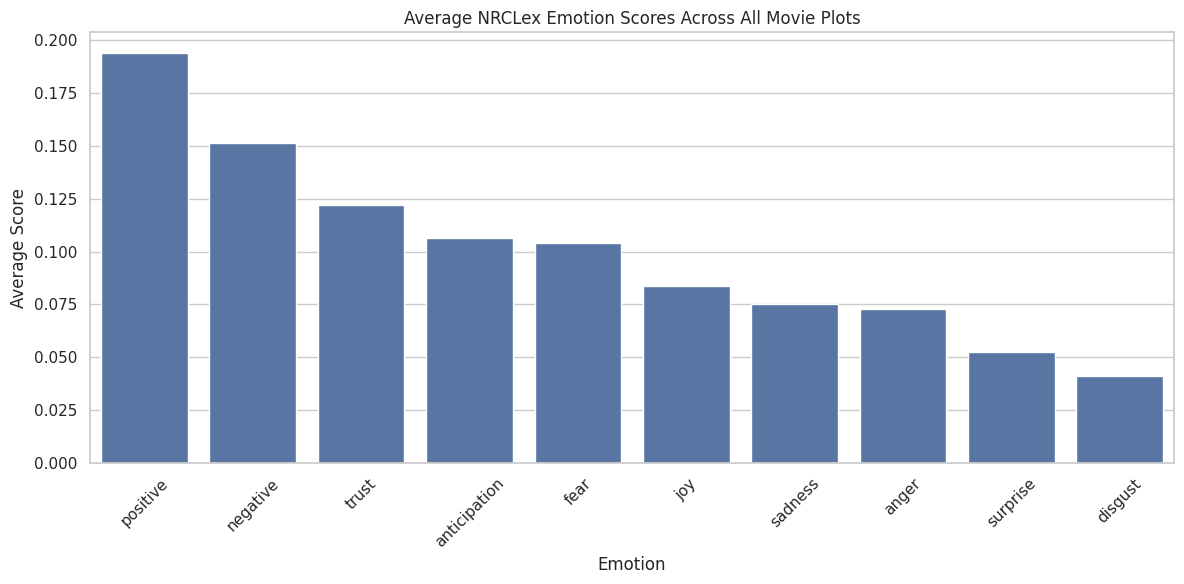

In [29]:
# Extract emotions into separate columns for plotting
nrclex_emotions_df = pd.DataFrame(movie_plot['nrclex_emotions'].dropna().tolist())
# Dropping column 'anticip' as it is a bug
nrclex_emotions_df = nrclex_emotions_df.drop(columns='anticip')
# Calculate mean values
means = nrclex_emotions_df.mean().sort_values(ascending=False)
means_df = means.reset_index()
means_df.columns = ['Emotion', 'Average Score']

plt.figure(figsize=(12,6))
sns.barplot(data=means_df, x='Emotion', y='Average Score')
plt.title('Average NRCLex Emotion Scores Across All Movie Plots')
plt.xlabel('Emotion')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Apparently positive and negative emotions are the most frequent, which is not surprising given how general they are. That anticip does not appear at all is a bug in the model, the correct emotion would be anticipation, more on that can be found [here](https://github.com/metalcorebear/NRCLex/issues/2), hence we have dropped it when plotting. That trust is the third common emotion is a bit surprising, but we will look into that in detail in milestone 3...

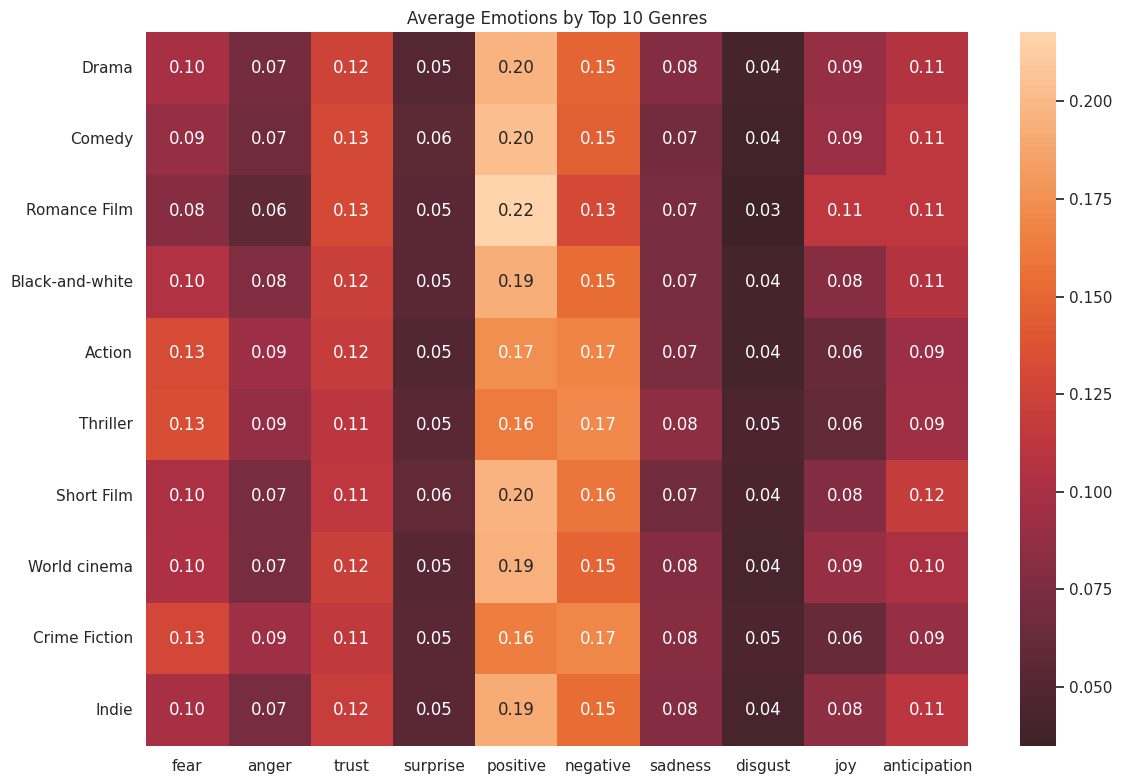

In [30]:
# Create a heatmap for the frequency of different emotions across genres
def plot_top_genres(df: pd.DataFrame, emotions_col: str):
    all_genres = []
    for genres in df['Genres'].dropna():
        all_genres.extend(genres)

    # Get 10 most common genres
    top_10_genres = pd.Series(all_genres).value_counts().head(10).index

    # Filter movies by top genres and get their emotions
    genre_emotions = {}
    for genre in top_10_genres:
        movies_in_genre = df[df['Genres'].dropna().apply(lambda g: genre in g)]
        genre_emotions_list = movies_in_genre[emotions_col].dropna().tolist()
        genre_emotions[genre] = pd.DataFrame(genre_emotions_list).mean()

    # Convert to DataFrame for plotting
    genre_emotions_df = pd.DataFrame(genre_emotions).T
    # Dropping 'anticip' again
    if 'anticip' in genre_emotions_df.columns:
        genre_emotions_df = genre_emotions_df.drop(columns='anticip')

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(genre_emotions_df, center=0, annot=True, fmt='.2f')
    plt.title('Average Emotions by Top 10 Genres')
    plt.tight_layout()
    plt.show()

plot_top_genres(movie_plot, 'nrclex_emotions')

Nice, we already get some interesting results, regarding the distribution of different emotions across genres. Again anticip should just be ignored. Surprise and sadness apparently do not really vary over different genres. We could already start our analysis with this data but lets see if we can get even better results with pretrained language models.

#### Extract emotions with the pre-trained roberta-base-go-emotions model
Extracting the emotions with a pre-trained language model takes a lot of time and requires gpu to run in reasonable time. Therefore we just did it on a small subsample to ensure feasibility and will then for milestone 3 perform it on the complete dataset on external ressources like the EPFL cluster or Google Colab. We will then save the created data file and add it to the project.

The model we use is from huggingface: https://huggingface.co/SamLowe/roberta-base-go_emotions. It extracts 28 emotions from a given text and returns a dictionary with each emotion and the corresponding value.

In [31]:
# Extracting emotions takes a lot of time especially without gpu, so we check feasability by only performing it on the first 800 datapoints
df_subset = movie_plot[:4000].copy()

# Process with progress bar
from tqdm import tqdm
tqdm.pandas()
df_subset['roberta_emotions'] = df_subset['Plot'].progress_apply(lambda x: get_emotions_roberta(x) if pd.notna(x) else None)

100%|█████████████████████████████| 4000/4000 [04:57<00:00, 13.44it/s]


#### Applying the pretrained model works very well! Let's plot the data we obtained and have a look at the top 3 emotions for the top 10 genres

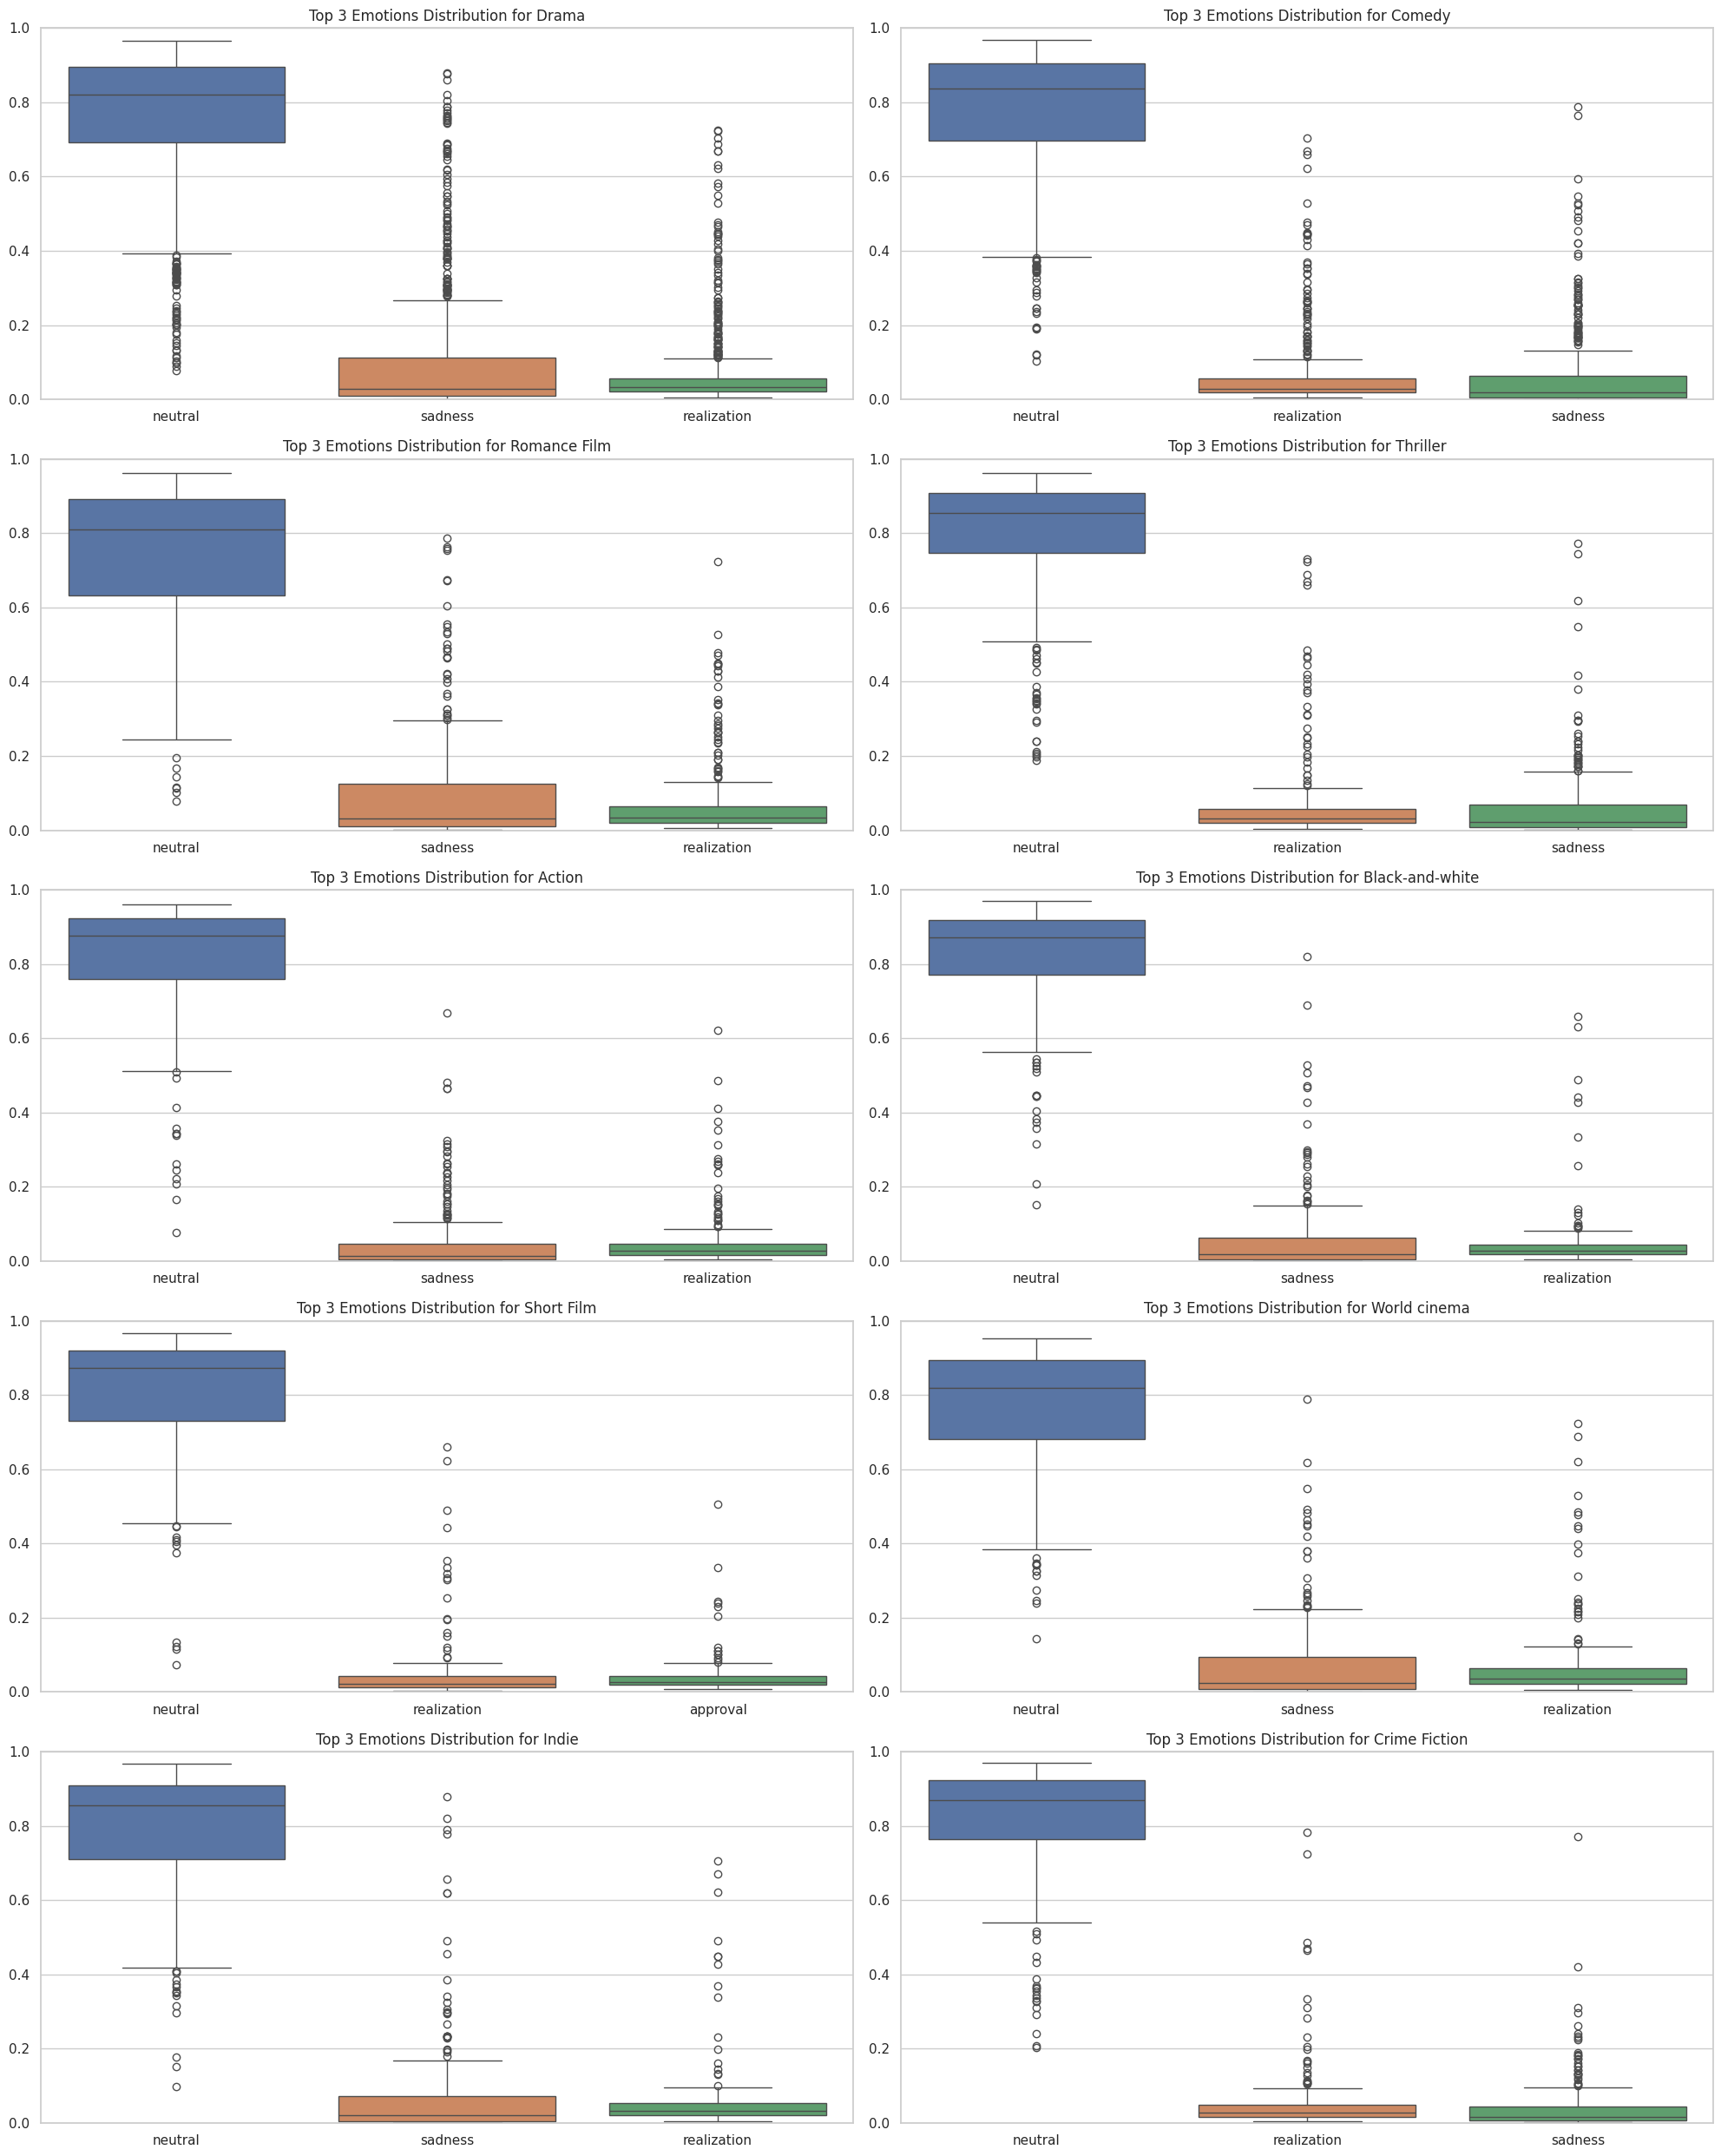

In [32]:
# Plot roberta emotions by genre

# Group by genre and get mean of each emotion
all_genres = []
for genres in df_subset['Genres'].dropna():
    all_genres.extend(genres)

# Get 10 most common genres
top_10_genres = pd.Series(all_genres).value_counts().head(10).index

# Create figure with subplots
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
axes = axes.flatten()

# For each genre, get all the movies that belong to it and plot emotion distributions
for i, genre in enumerate(top_10_genres):
    movies_in_genre = df_subset[df_subset['Genres'].apply(lambda x: genre in x)]
    roberta_emotions = movies_in_genre['roberta_emotions'].dropna()
    
    # Convert list of dicts to DataFrame for easier plotting
    roberta_emotions_df = pd.DataFrame(list(roberta_emotions))
    
    # Get top 3 emotions by mean value
    top_3_emotions_distilbert = roberta_emotions_df.mean().nlargest(3).index
    
    # Plot boxplot for this genre with only top 3 emotions
    sns.boxplot(data=roberta_emotions_df[top_3_emotions_distilbert], ax=axes[i])
    axes[i].set_title(f'Top 3 Emotions Distribution for {genre}')
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

That does not look too promising, the main emotion is always neutral and other then that it is most of the time realization and sadness. Let's see how it looks when we omit the neutral emotion for now and look at the top 5 emotions instead.

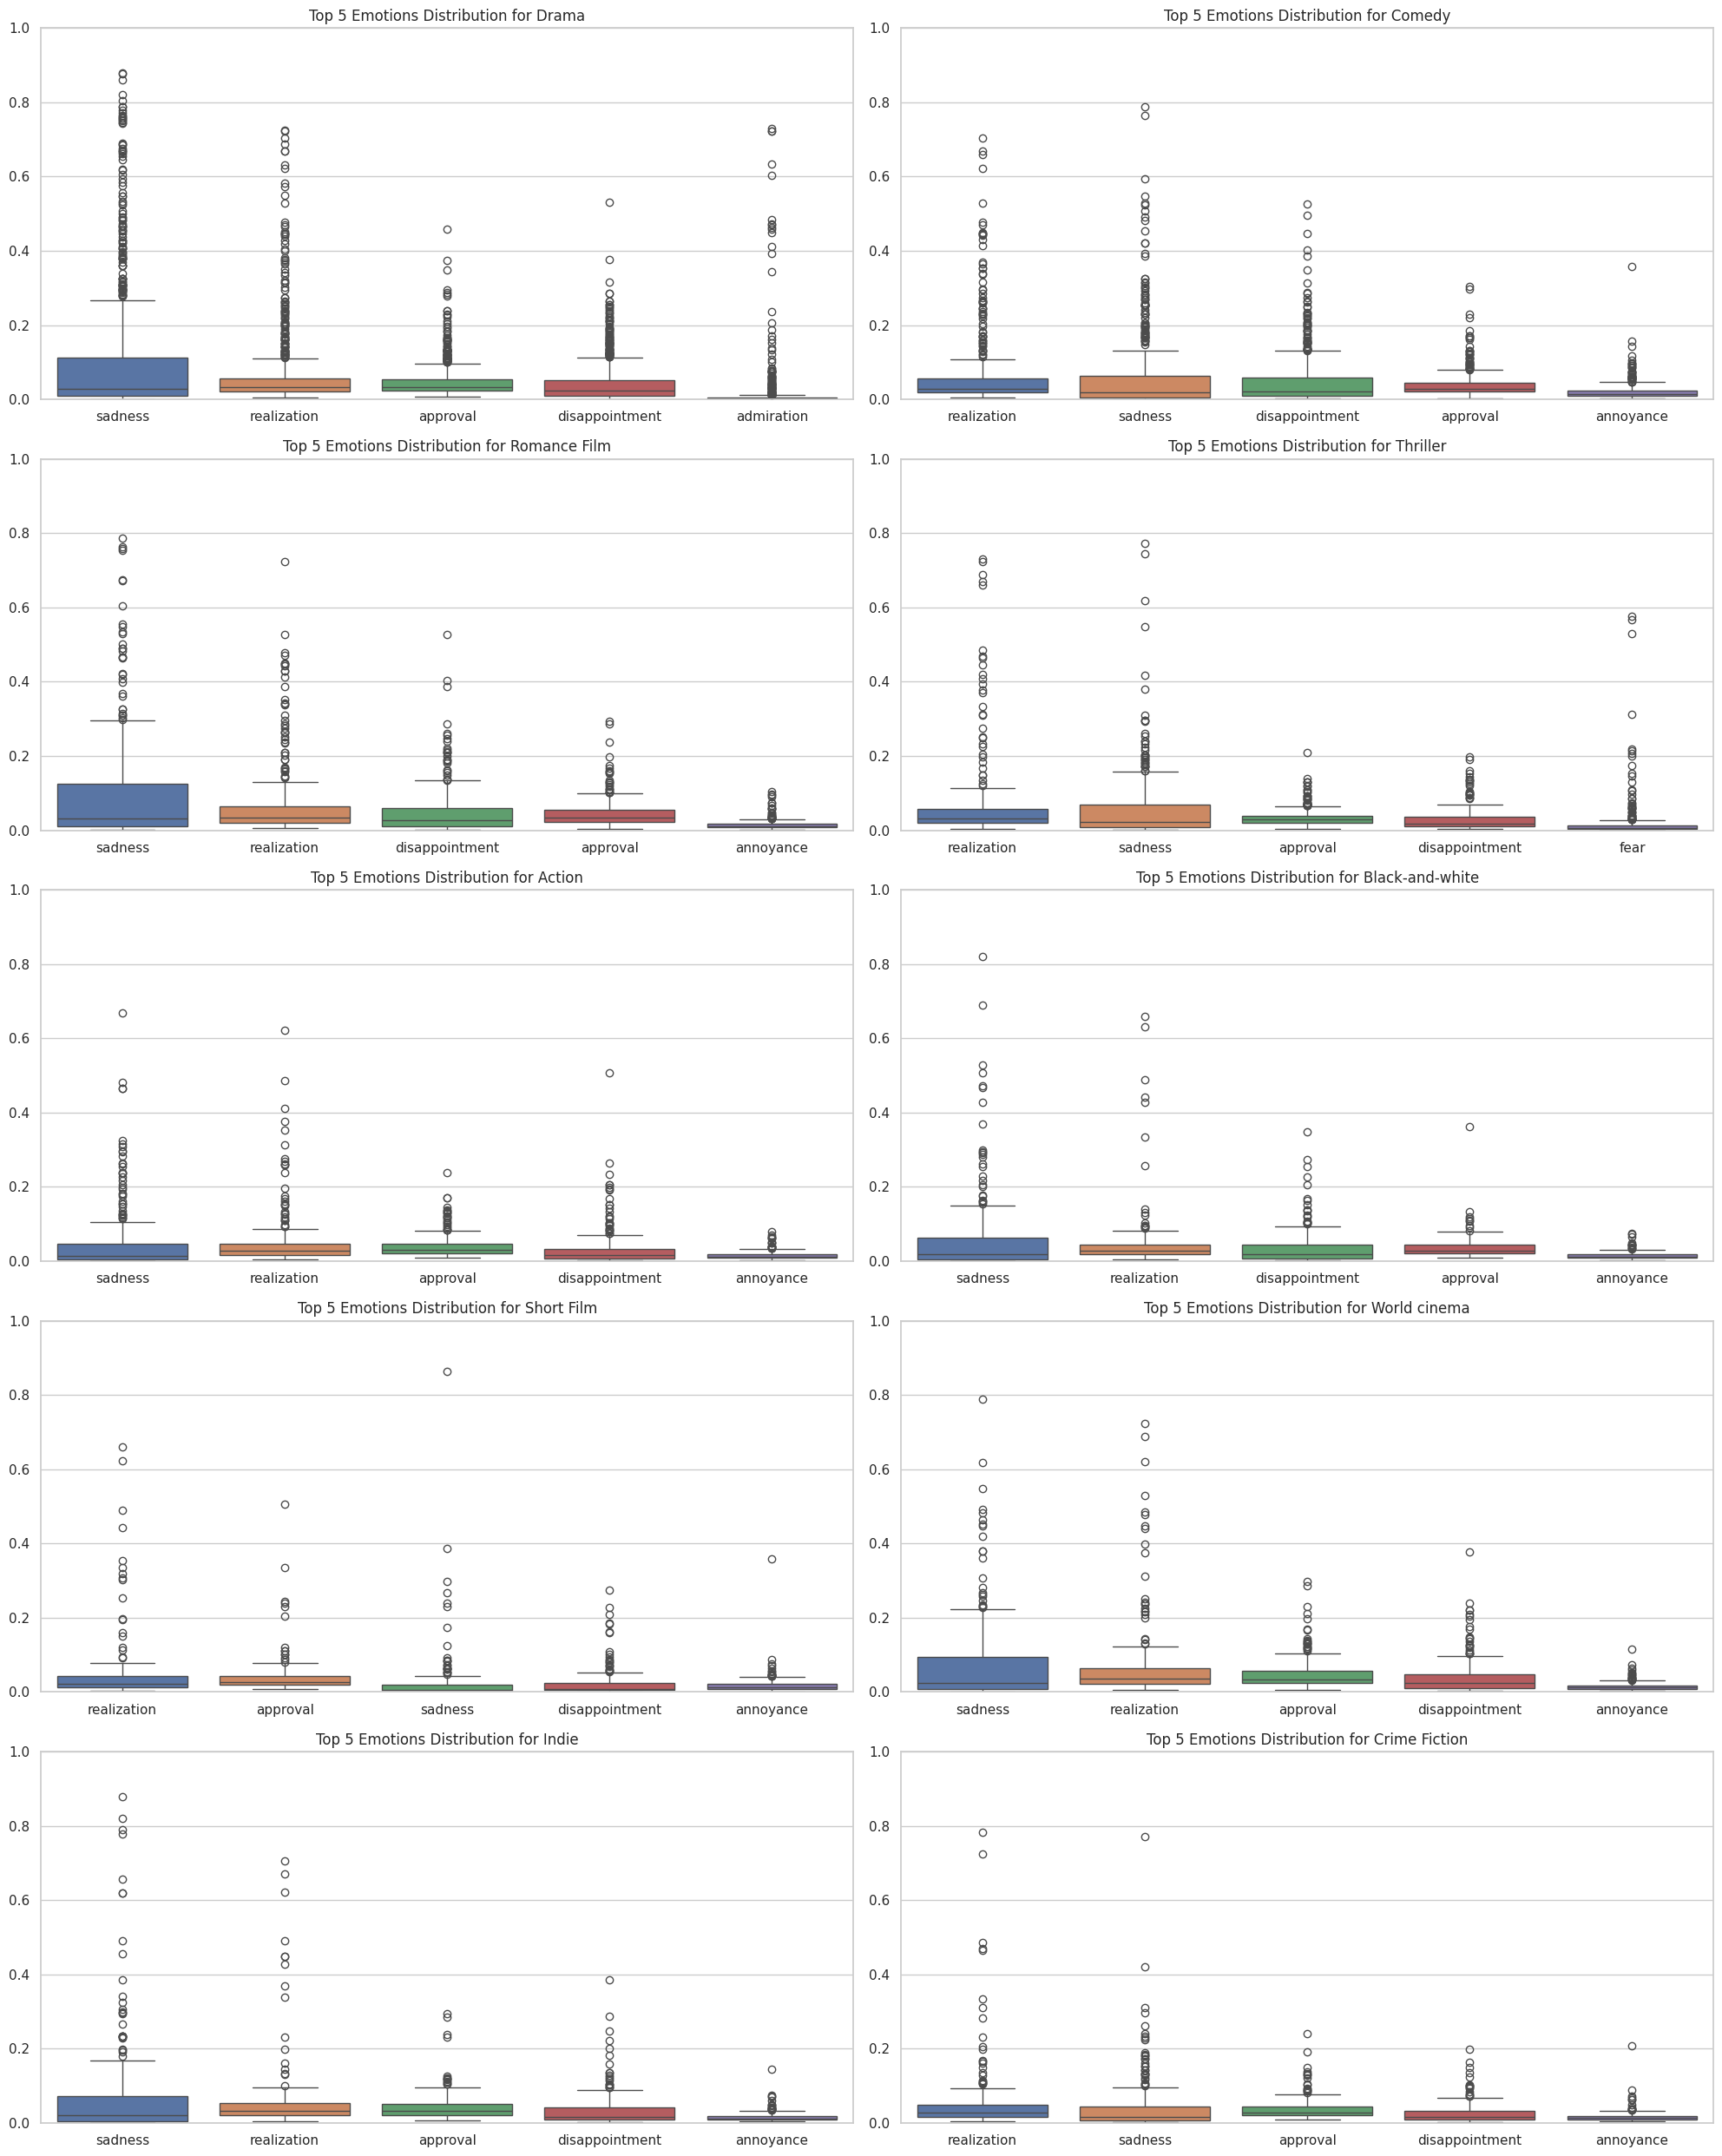

In [33]:
# Group by genre and get mean of each emotion
all_genres = []
for genres in df_subset['Genres'].dropna():
    all_genres.extend(genres)

# Get 10 most common genres
top_10_genres = pd.Series(all_genres).value_counts().head(10).index

# Create figure with subplots
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
axes = axes.flatten()

# For each genre, get all the movies that belong to it and plot emotion distributions
for i, genre in enumerate(top_10_genres):
    movies_in_genre = df_subset[df_subset['Genres'].apply(lambda x: genre in x)]
    roberta_emotions_no_neutral = movies_in_genre['roberta_emotions'].dropna()
    
    # Convert list of dicts to DataFrame for easier plotting
    emotions_df_no_neutral = pd.DataFrame(list(roberta_emotions_no_neutral))

    # Drop neutral
    emotions_df_no_neutral = emotions_df_no_neutral.drop(columns=['neutral'])
    
    # Get top 5 emotions by mean value
    top_5_emotions_no_neutral = emotions_df_no_neutral.mean().nlargest(5).index
    
    # Plot boxplot for this genre with only top 5 emotions
    plot = sns.boxplot(data=emotions_df_no_neutral[top_5_emotions_no_neutral], ax=axes[i])
    axes[i].set_title(f'Top 5 Emotions Distribution for {genre}')
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

This still does not look very promising, there are more or less always the same top 5 emotions for the top 10 genres and they are more or less evenly distributed. That makes sense because there are 28 different emotions which are probably sometimes similar to each other like sadness and disappointment. So it is difficult to really see a difference in the distribution of these emotions. Let's try another model which is a bit less fine grained and therefore can show clearer differences.

#### Extract emotions with the pre-trained emotion-english-distilroberta-base model
This model is also from huggingface: https://huggingface.co/j-hartmann/emotion-english-distilroberta-base. It extracts Ekman's 6 basic emotions and a neutral class from a given text and returns a dictionary with each emotion and the corresponding value.

Again we only apply it only on a subset to check feasability and then for milestone 3 run it on the complete data on external ressources and add the created data to our project.

In [34]:
# Use again the subset and apply with progress bar
df_subset['distilbert_emotions'] = df_subset['Plot'].progress_apply(lambda x: get_emotions_distilbert(x) if pd.notna(x) else None)

100%|█████████████████████████████| 4000/4000 [02:47<00:00, 23.87it/s]


#### This works fine as well! Let's look again at the top 3 emotions for the top 10 genres

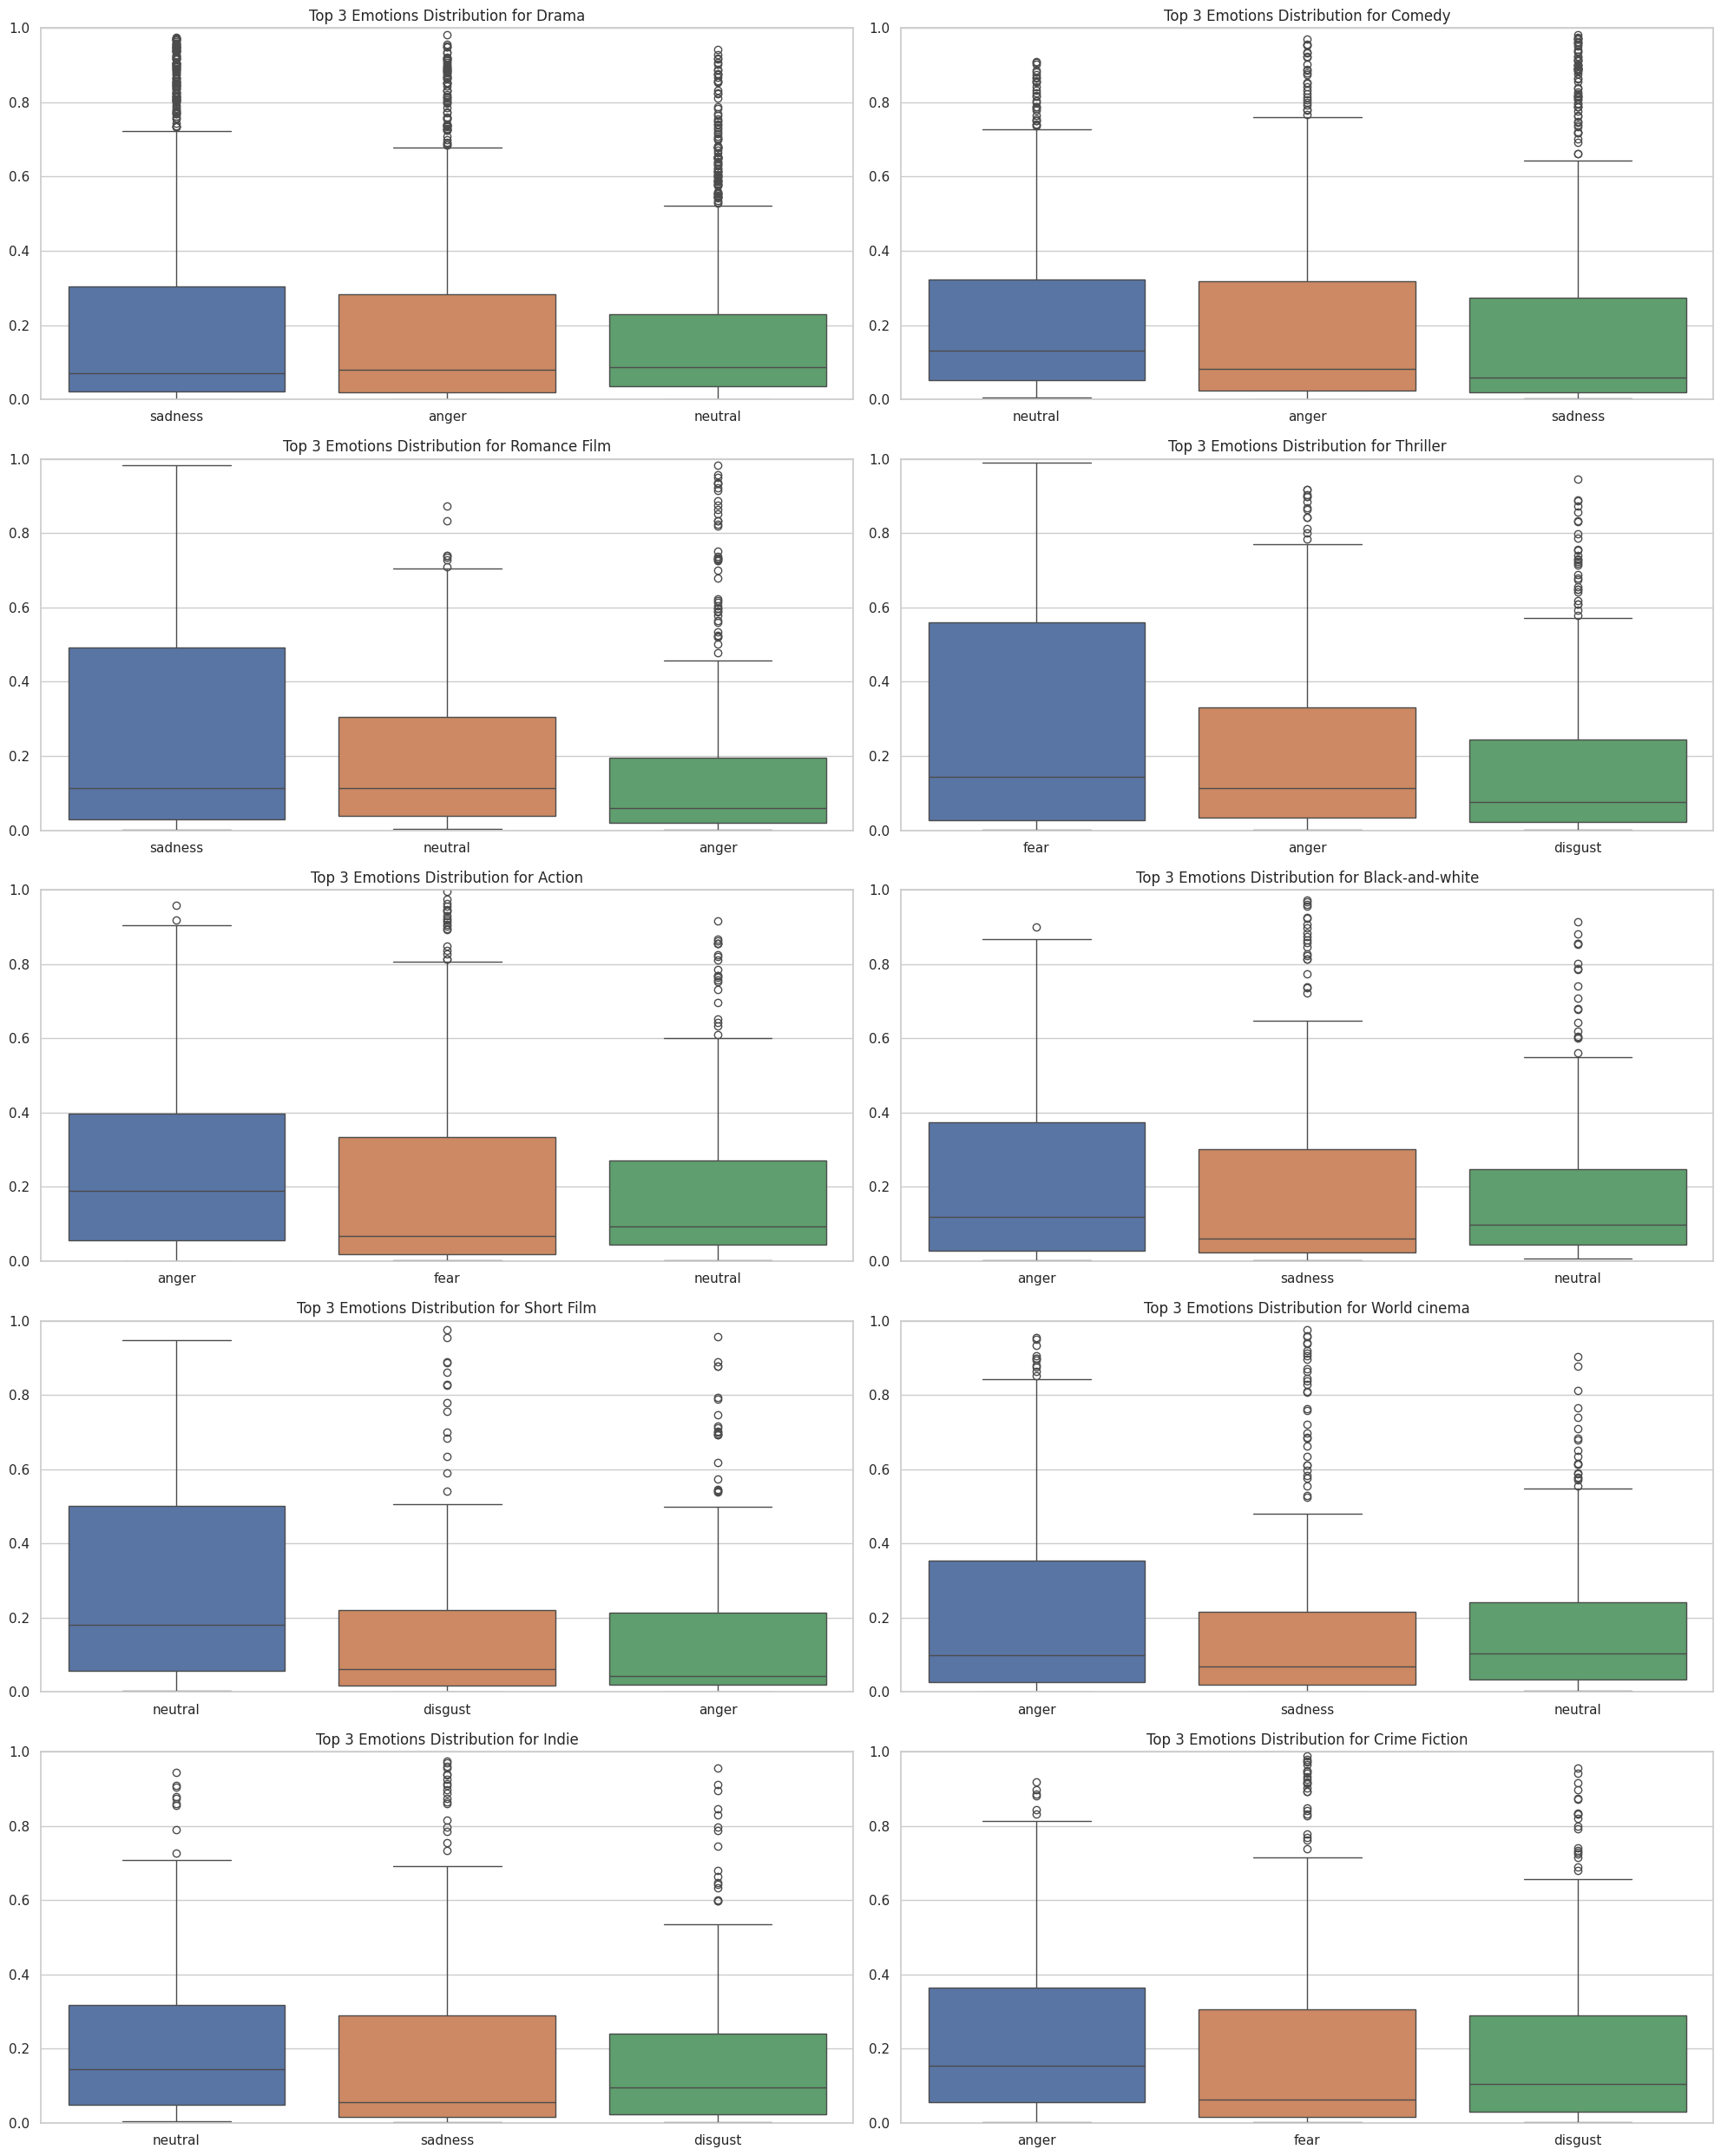

In [35]:
# Plot distilbert emotions by genre

# Group by genre and get mean of each emotion
all_genres = []
for genres in df_subset['Genres'].dropna():
    all_genres.extend(genres)

# Get 10 most common genres
top_10_genres = pd.Series(all_genres).value_counts().head(10).index

# Create figure with subplots
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
axes = axes.flatten()

# For each genre, get all the movies that belong to it and plot emotion distributions
for i, genre in enumerate(top_10_genres):
    movies_in_genre = df_subset[df_subset['Genres'].apply(lambda x: genre in x)]
    distilbert_emotions = movies_in_genre['distilbert_emotions'].dropna()
    
    # Convert list of dicts to DataFrame for easier plotting
    distilbert_emotions_df = pd.DataFrame(list(distilbert_emotions))
    
    # Get top 3 emotions by mean value
    top_3_emotions_distilbert = distilbert_emotions_df.mean().nlargest(3).index
    
    # Plot boxplot for this genre with only top 3 emotions
    sns.boxplot(data=distilbert_emotions_df[top_3_emotions_distilbert], ax=axes[i])
    axes[i].set_title(f'Top 3 Emotions Distribution for {genre}')
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

This looks way better, because we have less classes now there are clearer differences between the genres which is a great base for our further analyses.

Even though we only applied the emotion extraction on a subsample for now and will apply it on the whole dataset for milestone 3, we will add the three emotion extractions as columns to our data to have all columns which we will use for our final analysis.

In [36]:
# Add the emotions extracted for a subset with roberta and distilbert
movie_plot['roberta_emotions'] = df_subset['roberta_emotions']
movie_plot['distilbert_emotions'] = df_subset['distilbert_emotions']
# Check result
movie_plot.head()

,WikiID,FreebaseID,Name,ReleaseDate,Runtime,Languages_tuple,Countries_tuples,Genres_tuples,Languages,Countries,Genres,Plot,merge_year,nrclex_emotions,roberta_emotions,distilbert_emotions
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",2001,"{'fear': 0.16296296296296298, 'anger': 0.13333...","{'neutral': 0.8470946550369263, 'realization':...","{'fear': 0.43731892108917236, 'disgust': 0.417..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN,2000,None,None,None
2,28463795,/m/0crgdbh,Brun bitter,1988,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN,1988,None,None,None
3,9363483,/m/0285_cd,White Of The Eye,1987,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,1987,"{'fear': 0.1751412429378531, 'anger': 0.135593...","{'neutral': 0.9385933876037598, 'approval': 0....","{'anger': 0.8638681173324585, 'disgust': 0.079..."
4,261236,/m/01mrr1,A Woman in Flames,1983,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...",1983,"{'fear': 0.0673076923076923, 'anger': 0.105769...","{'neutral': 0.8754806518554688, 'approval': 0....","{'anger': 0.6429340243339539, 'disgust': 0.206..."


---

### Character Data

After extracting the emotions now we will look at the remaining data, starting with the character data.

In [37]:
# Import character metadata
characters = pd.read_csv(f'{PREFIX_PATH}/MovieSummaries/character.metadata.tsv', sep= '\t', header=None)
characters.columns = ['WikiMovieID', 'FreebaseMovieID', 'MovieReleaseDate','CharacterName',
                      'ActorBirthDate', 'ActorGender', 'ActorHeight','ActorEthnicity', 
                      'ActorName', 'ActorAge', 'CharacterActorMap', 'CharacterID', 'ActorID']
characters.head()

,WikiMovieID,FreebaseMovieID,MovieReleaseDate,CharacterName,ActorBirthDate,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAge,CharacterActorMap,CharacterID,ActorID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


#### Lets delve deeper into the character dataset

In [38]:
# Check for missing values
pd.isna(characters).sum() / len(characters)

WikiMovieID          0.000000
FreebaseMovieID      0.000000
MovieReleaseDate     0.022178
CharacterName        0.572205
ActorBirthDate       0.235528
ActorGender          0.101203
ActorHeight          0.656457
ActorEthnicity       0.764665
ActorName            0.002725
ActorAge             0.350841
CharacterActorMap    0.000000
CharacterID          0.572183
ActorID              0.001808
dtype: float64

Apparently a lot of values for the ethnicity of actors is missing. For us the age and gender seem more important in regards of the influence of emotions in movies so we will not use the ethnicity. Furthermore the height and name of an actor is not interesting for us as well as the CharacterActorMap, CharacterID and the ActorID because they refer to freebase which does not exist anymore. We do not intend to use the CharacterName for now but maybe it will useful later. Lets get rid of the columns we won't use to make the data more easy to understand.

In [39]:
# Drop unused columns
characters = characters.drop(['ActorHeight', 'ActorEthnicity', 'ActorName', 'CharacterActorMap', 'CharacterID', 'ActorID'], axis=1)
characters.head()

,WikiMovieID,FreebaseMovieID,MovieReleaseDate,CharacterName,ActorBirthDate,ActorGender,ActorAge
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,42.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,27.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,32.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,33.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,23.0


From the remaining columns we will use ActorGender and ActorAge for our analysis. Therefore we should replace NaN values. For the age we will try to calculate it from the movie release date and the actor birth date. If this does not work we just use the mean which is a common technique. For the gender we will first look what is the distribution of the gender across the actors in the dataset and generate the gender randomly according to the distribution.

In [40]:
# Convert birth and movie release date to datetime
from utils.methods import clean_date, calculate_age

characters['ActorBirthDate'] = characters['ActorBirthDate'].apply(clean_date)
characters['MovieReleaseDate'] = characters['MovieReleaseDate'].apply(clean_date)

# Recalculate age for all rows where the age is NaN
# This will take around 4min
characters['ActorAge'] = characters.apply(
    lambda row: calculate_age(characters, row['ActorBirthDate'], row['MovieReleaseDate']) if pd.isna(row['ActorAge']) else row['ActorAge'], 
    axis=1)

In [41]:
# Replace NaN values in gender with a value according to distribution
gender_distribution = characters['ActorGender'].value_counts(normalize=True)

def assign_random_gender():
    return np.random.choice(gender_distribution.index, p=gender_distribution.values)

characters['ActorGender'] = characters['ActorGender'].apply(lambda x: assign_random_gender() if pd.isna(x) else x)

# Check if NaN values are successfully replaced
pd.isna(characters).sum() / len(characters)

WikiMovieID         0.000000
FreebaseMovieID     0.000000
MovieReleaseDate    0.022211
CharacterName       0.572205
ActorBirthDate      0.235579
ActorGender         0.000000
ActorAge            0.000000
dtype: float64

The actor gender is not numerically encoded which makes a little bit more difficult to calculate distributions and other statistics. So we add a column ActorGenderFlag which encodes the gender numerically. First we will check which values for the gender exist in the data and then encode the values numerically.

In [42]:
characters['ActorGender'].value_counts()

M    300716
F    149953
Name: ActorGender, dtype: int64

In [43]:
# Flag will be 0 if the actor is male and 1 if the actor is female
characters['ActorGenderFlag'] = np.where(characters['ActorGender'] == 'F', 1, 0)
characters.head()

,WikiMovieID,FreebaseMovieID,MovieReleaseDate,CharacterName,ActorBirthDate,ActorGender,ActorAge,ActorGenderFlag
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26 00:00:00,F,42.0,1
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15 00:00:00,F,27.0,1
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15 00:00:00,M,32.0,0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12 00:00:00,M,33.0,0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25 00:00:00,F,23.0,1


Lets get a first overview over the distribution of values on the remaining data.

In [44]:
characters.describe()

,WikiMovieID,ActorAge,ActorGenderFlag
count,4.506690e+05,450669.000000,450669.000000
mean,1.396975e+07,38.386498,0.332734
std,1.079662e+07,17.284183,0.471193
min,3.300000e+02,-7896.000000,0.000000
25%,3.759292e+06,31.000000,0.000000
50%,1.189065e+07,37.788523,0.000000
75%,2.366501e+07,44.000000,1.000000
max,3.750192e+07,156.000000,1.000000


The average age of actors is 37 but has a high standard deviation so it seems to vary a lot. From the included actors around 70% are male and 30% are female. Which seems weird is the minimum age of -7896 and the maximum age of 103. The maximum age could be realistic but the minimum age definitely not. So lets check all age values below 0 to identify potential mistakes in the data.

In [45]:
extreme_ages = characters[(characters['ActorAge'] <= 0)]
print("Number of datapoints with an age below 0: ", len(extreme_ages))
extreme_ages

Number of datapoints with an age below 0:  470


,WikiMovieID,FreebaseMovieID,MovieReleaseDate,CharacterName,ActorBirthDate,ActorGender,ActorAge,ActorGenderFlag
767,15007384,/m/03h4h5p,1934-05-02,NaN,1963-11-07 00:00:00,M,-29.0,0
2286,2553539,/m/07mlsy,1918-04-14,NaN,1931-03-25 00:00:00,M,-12.0,0
3892,5917218,/m/0fdf3y,1965-01-01,NaN,1983-03-03 00:00:00,F,-18.0,1
6666,73930,/m/0jsjm,1924-01-01,Robert,1972-11-07 00:00:00,M,-48.0,0
7188,21242801,/m/05bzjwj,1955-08-07,NaN,1973-08-01 00:00:00,M,-17.0,0
...,...,...,...,...,...,...,...,...
446581,25868401,/m/09v6ykm,1955-01-01,NaN,1967-05-31 00:00:00,F,-12.0,1
446583,8595532,/m/02799cv,1944-02-23,NaN,1947-05-28 00:00:00,M,-3.0,0
446816,1276915,/m/04pg6m,1941-06-20,NaN,1957-04-19 00:00:00,M,-15.0,0
447210,23382222,/m/06w1hlj,1932-08-09,NaN,1942-02-08 00:00:00,M,-9.0,0


Apparently there are 470 datapoints with a negative age. These ages have to be a mistake of some kind, which can also be seen when looking at the birth date. For each negative value we correct the age by calculating the correct age with the birth date and movie release date, we will use the code from before but adjust it slightly to clean negative values correctly even if one of the dates might be wrong and clean unrealistic high values as well.

In [46]:
from utils.methods import calculate_age_non_negative

# Recalculate age for all rows where the age is below 0 or above 103
characters['ActorAge'] = characters.apply(
    lambda row: calculate_age_non_negative(characters, row['ActorBirthDate'], row['MovieReleaseDate']) if row['ActorAge'] < 0 or row['ActorAge'] >= 103 else row['ActorAge'], 
    axis=1)

# Check the results
characters.describe()

,WikiMovieID,ActorAge,ActorGenderFlag
count,4.506690e+05,450669.000000,450669.000000
mean,1.396975e+07,38.454323,0.332734
std,1.079662e+07,12.312417,0.471193
min,3.300000e+02,0.000000,0.000000
25%,3.759292e+06,31.000000,0.000000
50%,1.189065e+07,37.788523,0.000000
75%,2.366501e+07,44.000000,1.000000
max,3.750192e+07,100.000000,1.000000


Now the values seem realistic and are prepared for further analysis. In a last step we look at the distribution of the age and gender which we want to use later on for further analysis to get an idea of the data we work with.

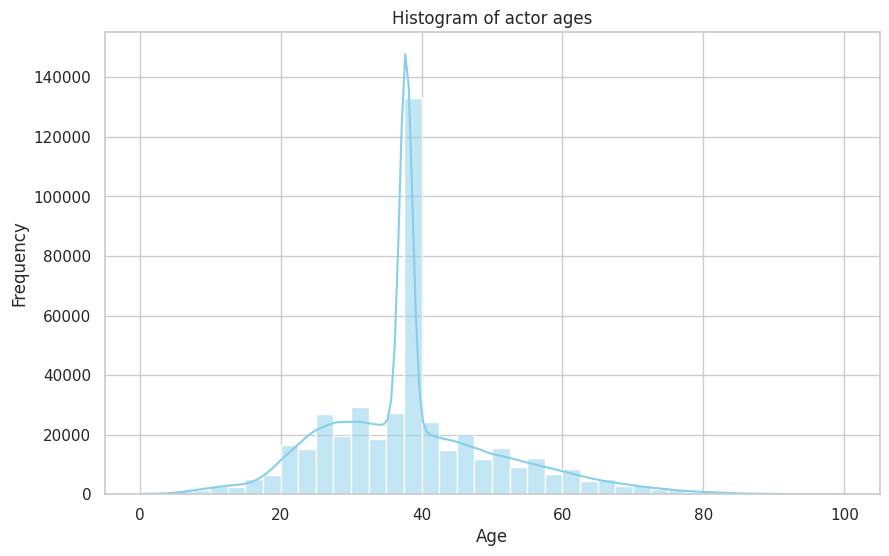

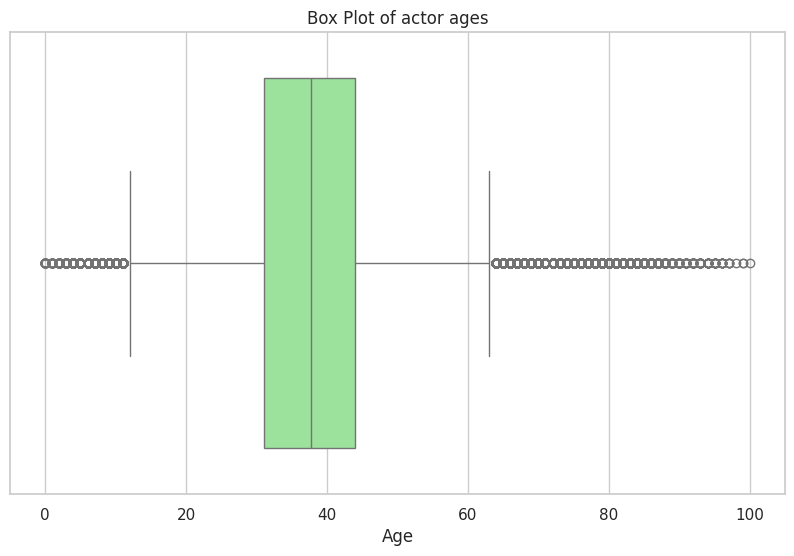

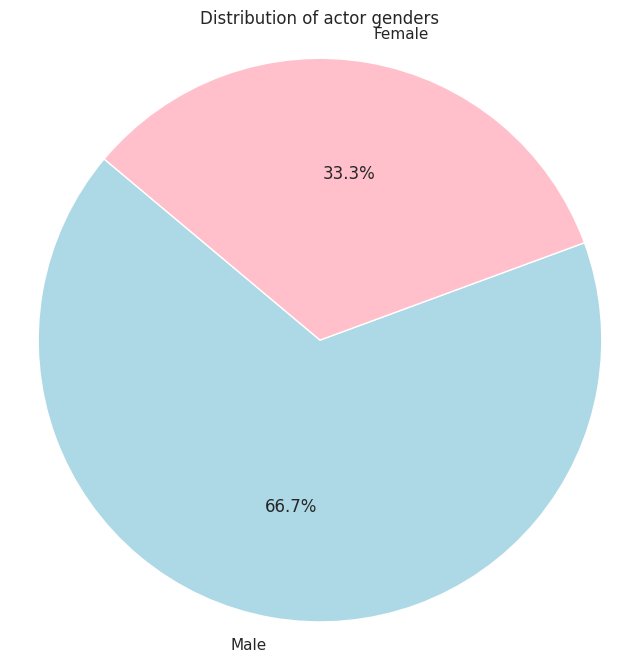

In [47]:
# Histogram for the age of actors
plt.figure(figsize=(10, 6))
sns.histplot(characters['ActorAge'], bins=40, kde=True, color='skyblue')
plt.title("Histogram of actor ages")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Box Plot for age of actors
plt.figure(figsize=(10, 6))
sns.boxplot(x=characters['ActorAge'], color='lightgreen')
plt.title("Box Plot of actor ages")
plt.xlabel("Age")
plt.show()

# Pie Chart for the gender of actors using the ActorGenderFlag
gender_counts = characters['ActorGenderFlag'].value_counts()
labels = ['Male', 'Female'] 
colors = ['lightblue', 'pink']
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of actor genders")
plt.axis('equal')
plt.show()

The visualizations show what we already saw with describe() earlier. The age is more or less evenly distributed around the mean of 37. The boxplot shows that the middle 50% of the ages are roughly between 15 and 62. 

The gender is not evenly distributed. Around 2/3 of the actors which are included in the data are male. This has to be considered in later analyses especially when looking at impact of emotions in a movie on the gender of selected actors in that movie.

We can now merge the character data into our main dataset.

In [48]:
# Helper function to convert a series to a list
def to_list(series):
    return series.tolist()

# Group character data by WikiMovieID to get a list of characters for each movie
characters_grouped = characters.groupby('WikiMovieID').agg({
    'CharacterName': to_list,
    'ActorAge': to_list,
    'ActorGender': to_list,
    'ActorBirthDate': to_list,
    'ActorGenderFlag': to_list,
})

In [49]:
# Now we can merge the character_instances with the movie_plot dataset
movie_plot_char = movie_plot.merge(characters_grouped, left_on = 'WikiID', right_on = 'WikiMovieID', how='left')
# Check result
movie_plot_char.head()

,WikiID,FreebaseID,Name,ReleaseDate,Runtime,Languages_tuple,Countries_tuples,Genres_tuples,Languages,Countries,Genres,Plot,merge_year,nrclex_emotions,roberta_emotions,distilbert_emotions,CharacterName,ActorAge,ActorGender,ActorBirthDate,ActorGenderFlag
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",2001,"{'fear': 0.16296296296296298, 'anger': 0.13333...","{'neutral': 0.8470946550369263, 'realization':...","{'fear': 0.43731892108917236, 'disgust': 0.417...","[Akooshay, Lieutenant Melanie Ballard, Desolat...","[42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, 37....","[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...","[1958-08-26 00:00:00, 1974-08-15 00:00:00, 196...","[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN,2000,None,None,None,"[Police Officer, Reporter, nan, nan, FBI Profi...","[37.78852253927453, 43.0, 37.78852253927453, 3...","[M, F, M, F, M, M, M, F, F, M, M, M, M, M, M]","[NaT, 1956-12-19 00:00:00, NaT, NaT, 1950-01-0...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]"
2,28463795,/m/0crgdbh,Brun bitter,1988,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN,1988,None,None,None,"[nan, nan, nan, nan]","[33.0, 28.0, 40.0, 30.0]","[M, F, M, F]","[1954-10-05 00:00:00, 1959-02-28 00:00:00, 194...","[0, 1, 0, 1]"
3,9363483,/m/0285_cd,White Of The Eye,1987,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,1987,"{'fear': 0.1751412429378531, 'anger': 0.135593...","{'neutral': 0.9385933876037598, 'approval': 0....","{'anger': 0.8638681173324585, 'disgust': 0.079...","[nan, nan]","[32.0, 26.0]","[M, F]","[1954-05-08 00:00:00, 1960-11-29 00:00:00]","[0, 1]"
4,261236,/m/01mrr1,A Woman in Flames,1983,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...",1983,"{'fear': 0.0673076923076923, 'anger': 0.105769...","{'neutral': 0.8754806518554688, 'approval': 0....","{'anger': 0.6429340243339539, 'disgust': 0.206...","[nan, nan, nan]","[32.0, 32.0, 35.0]","[F, M, M]","[1950-06-20 00:00:00, 1950-08-02 00:00:00, 194...","[1, 0, 0]"


---

### External Rating Data

To discover the influence of different emotions in movies on the success of a movie we need some kind of measurement for the success of a movie. We decided to use user rating for this purpose. Unfortunately the provided data does not contain movie ratings so we searched for an external dataset and will use the MovieLens 32M dataset: https://grouplens.org/datasets/movielens/. It contains 32 million reviews for 87585 movies and therefore should provide valuable insights.

In [50]:
# Import movie lens ratings
ratings = pd.read_csv(f'{PREFIX_PATH}/ml-32m/ratings.csv')
ratings.shape

(32000204, 4)

In [51]:
# Import movie lens movies
m_ratings = pd.read_csv(f'{PREFIX_PATH}/ml-32m/movies.csv')
m_ratings.shape

(87585, 3)

In [52]:
# Aggregate the ratings for each movie
grouped_ratings = ratings.groupby('movieId')['rating'].agg(
    mean_ratings = 'mean',
    std_dev_ratings = 'std',
    count_ratings = 'count'
).reset_index()
grouped_ratings.shape

(84432, 4)

In [53]:
# Merge the ratings and movies
name_ratings = m_ratings.iloc[:,:2].merge(grouped_ratings, on='movieId', how='left')
name_ratings.head()

,movieId,title,mean_ratings,std_dev_ratings,count_ratings
0,1,Toy Story (1995),3.897438,0.921450,68997.0
1,2,Jumanji (1995),3.275758,0.955544,28904.0
2,3,Grumpier Old Men (1995),3.139447,1.012273,13134.0
3,4,Waiting to Exhale (1995),2.845331,1.105871,2806.0
4,5,Father of the Bride Part II (1995),3.059602,0.999079,13154.0


#### Check for missing values

In [54]:
print(name_ratings.isna().sum() / len(name_ratings))

movieId            0.000000
title              0.000000
mean_ratings       0.035999
std_dev_ratings    0.248444
count_ratings      0.035999
dtype: float64


Fortunately there are no missing values for the movieId and the title, this is important for merging the data. Also there are only very little missing values for the ratings, however movies without ratings don't provide any value to us so we will drop rows where the mean_ratings attribute is missing. The standard deviation and count is not used directly so we will keep them but don't drop rows just because they have missing values.

In [55]:
name_ratings = name_ratings.dropna(subset=["mean_ratings"])

# Check result
print(name_ratings.isna().sum() / len(name_ratings))

movieId            0.000000
title              0.000000
mean_ratings       0.000000
std_dev_ratings    0.220379
count_ratings      0.000000
dtype: float64


Now that we have the rating data ready we will prepare it to merge it with our main dataset. Unfortunately we can't merge with the IDs which would be ideal, because they don't match and we couldn't find a source where the different IDs are matched. So we will use the processed title and year of each movie to merge the dataset.

In [56]:
# Use regex to clean title and year for merging
name_ratings['merge_title'] = name_ratings['title'].str.extract(r'^(.*?)(?=\s\()')[0].str.lower()
name_ratings['merge_year'] = name_ratings['title'].str.extract(r'\((\d{4})\)')[0].astype('Int64')

# Clean title for merging
movie_plot_char['merge_title'] = movie_plot_char['Name'].str.lower().str.strip()

# Merge ratings with main data
df_final = movie_plot_char.merge(name_ratings, on = ['merge_title', 'merge_year'], how = 'left')

# Check result
df_final.head()

,WikiID,FreebaseID,Name,ReleaseDate,Runtime,Languages_tuple,Countries_tuples,Genres_tuples,Languages,Countries,Genres,Plot,merge_year,nrclex_emotions,roberta_emotions,distilbert_emotions,CharacterName,ActorAge,ActorGender,ActorBirthDate,ActorGenderFlag,merge_title,movieId,title,mean_ratings,std_dev_ratings,count_ratings
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",2001,"{'fear': 0.16296296296296298, 'anger': 0.13333...","{'neutral': 0.8470946550369263, 'realization':...","{'fear': 0.43731892108917236, 'disgust': 0.417...","[Akooshay, Lieutenant Melanie Ballard, Desolat...","[42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, 37....","[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...","[1958-08-26 00:00:00, 1974-08-15 00:00:00, 196...","[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",ghosts of mars,4735.0,Ghosts of Mars (2001),2.35196,1.064942,1709.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN,2000,None,None,None,"[Police Officer, Reporter, nan, nan, FBI Profi...","[37.78852253927453, 43.0, 37.78852253927453, 3...","[M, F, M, F, M, M, M, F, F, M, M, M, M, M, M]","[NaT, 1956-12-19 00:00:00, NaT, NaT, 1950-01-0...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]",getting away with murder: the jonbenét ramsey ...,NaN,NaN,NaN,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN,1988,None,None,None,"[nan, nan, nan, nan]","[33.0, 28.0, 40.0, 30.0]","[M, F, M, F]","[1954-10-05 00:00:00, 1959-02-28 00:00:00, 194...","[0, 1, 0, 1]",brun bitter,NaN,NaN,NaN,NaN,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,1987,"{'fear': 0.1751412429378531, 'anger': 0.135593...","{'neutral': 0.9385933876037598, 'approval': 0....","{'anger': 0.8638681173324585, 'disgust': 0.079...","[nan, nan]","[32.0, 26.0]","[M, F]","[1954-05-08 00:00:00, 1960-11-29 00:00:00]","[0, 1]",white of the eye,90015.0,White of the Eye (1987),3.00000,1.038328,33.0
4,261236,/m/01mrr1,A Woman in Flames,1983,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...",1983,"{'fear': 0.0673076923076923, 'anger': 0.105769...","{'neutral': 0.8754806518554688, 'approval': 0....","{'anger': 0.6429340243339539, 'disgust': 0.206...","[nan, nan, nan]","[32.0, 32.0, 35.0]","[F, M, M]","[1950-06-20 00:00:00, 1950-08-02 00:00:00, 194...","[1, 0, 0]",a woman in flames,NaN,NaN,NaN,NaN,NaN


#### Let's have a last look at the data after merging the ratings...

In [57]:
# Analyze the ratings per genre
df_genres_expanded = df_final.explode('Genres').reset_index()
top_genres = df_genres_expanded ['Genres'].value_counts().nlargest(9).index
df_genres_expanded['Genres'] = df_genres_expanded['Genres'].apply(lambda x: x if x in top_genres else 'Other')

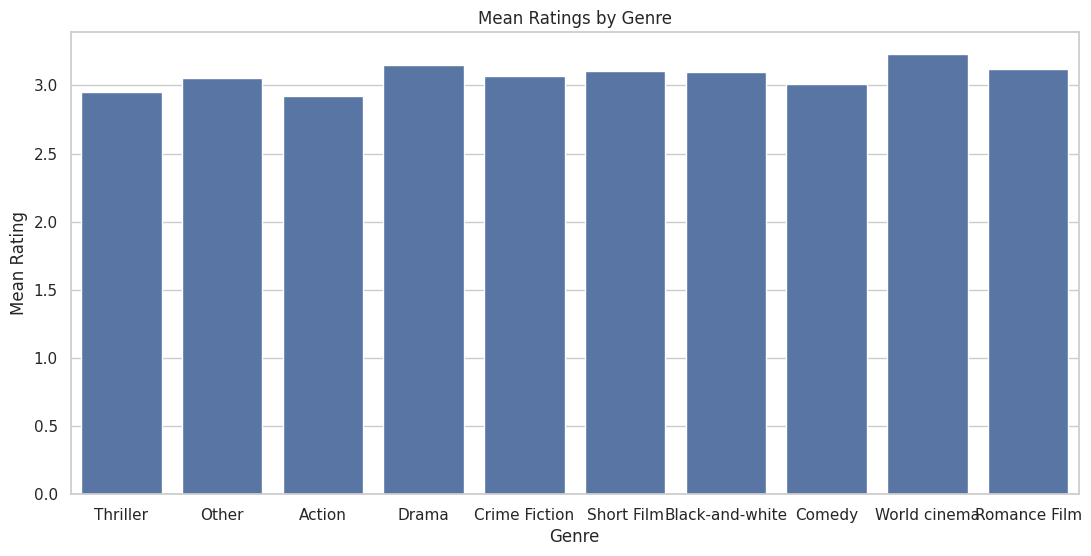

In [58]:
# Plot the mean ratings per genre
plt.figure(figsize=(13, 6))
sns.barplot(data=df_genres_expanded, x='Genres', y='mean_ratings', estimator='mean', errorbar=None)

# Set plot labels and title
plt.xlabel('Genre')
plt.ylabel('Mean Rating')
plt.title('Mean Ratings by Genre')
plt.show()

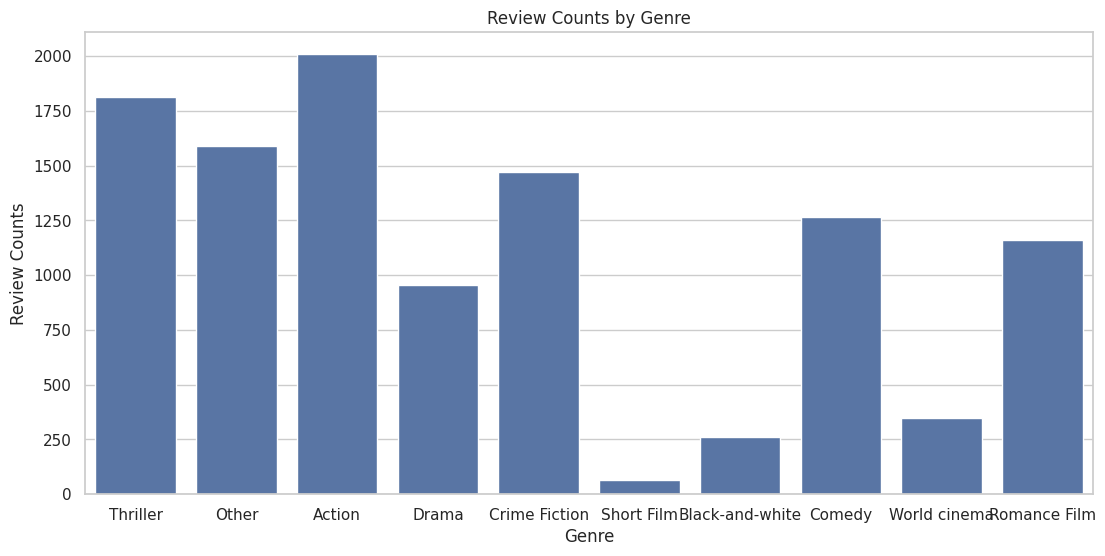

In [59]:
# Plot the number of ratings per genre
plt.figure(figsize=(13, 6))
sns.barplot(data=df_genres_expanded, x='Genres', y='count_ratings', estimator='mean', errorbar=None)

# Set plot labels and title
plt.xlabel('Genre')
plt.ylabel('Review Counts')
plt.title('Review Counts by Genre')
plt.show()

### Finished!

Now our data is ready for further analysis, which we will conduct in milestone 3. As mentioned above the emotion extraction will probably be done on external ressources for all plots due to runtime considerations. We went through all datasets that we want to use, cleaned them, conducted a first overall analysis and then merged it. We always used left join, therefore even after cleaning we have NaN values in our data when the data did not match exactly at merging. That is an explicit choice, to not loose data through the different steps because many analysises will be conducted only on parts of the data where we then will have more datapoints left compared to an inner join at each step. The NaN values are no problem because we know which columns can contain NaN values and therefore we can easily handle them during the analyis. We will now print some overall statistics of our final data and save it for later use.

The amount of languages and genres might seem high but the values are correct if you look at the data there are just a lot of different values for these attributes. As shown we have dataloss in every merging step but it is not too high for our analysis. Even in the last step with rating we have roughly 15000 datapoints which should be enough for meaningful analysises.

In [60]:
df_final.to_csv(f"{PREFIX_PATH}/final_data.csv", index=False)

In [61]:
# Final numbers
total_data_points = len(df_final)

# Data points for movies with plots
movies_with_plot = df_final[df_final["Plot"].notna()]
num_movies_with_plot = len(movies_with_plot)

# Data points for movies with characters and plot summaries
movies_with_characters_and_plot = movies_with_plot[movies_with_plot["CharacterName"].notna()]
num_movies_with_characters_and_plot = len(movies_with_characters_and_plot)

# Data points for movies with characters, plot summaries, and ratings
movies_with_characters_plot_ratings = movies_with_characters_and_plot[
    movies_with_characters_and_plot["mean_ratings"].notna()
]
num_movies_with_characters_plot_ratings = len(movies_with_characters_plot_ratings)

# Number of different genres
unique_genres = df_final["Genres"].explode().dropna().unique()
num_genres = len(unique_genres)

# Number of different languages
unique_languages = df_final["Languages"].explode().dropna().unique()
num_languages = len(unique_languages)

# Print results
print("Total number of data points:", total_data_points)
print("Number of movies with plot summaries:", num_movies_with_plot)
print("Number of movies with characters and plot summaries:", num_movies_with_characters_and_plot)
print("Number of movies with characters, plot summaries, and ratings:", num_movies_with_characters_plot_ratings)
print("Number of different genres:", num_genres)
print("Number of different languages:", num_languages)

Total number of data points: 81804
Number of movies with plot summaries: 42249
Number of movies with characters and plot summaries: 37824
Number of movies with characters, plot summaries, and ratings: 15952
Number of different genres: 363
Number of different languages: 207


---

### Methods
Now we will provide an overview over the methods we intend to use, how they work and how we will use them

#### Method 1: Natural Language Processing

To uncover how films use emotions and analyze their evolution and impact, we detect emotions from movie plot summaries sourced from Wikipedia. The movie metadata is merged with character metadata and plot summaries to create a unified dataset. Emotions are then extracted using various pre-trained models.

This has already been done above. This dataset has been expanded to include a probability score for each of eight distinct emotions associated with every movie plot.

#### Method 2: Aggregation and Comparison

To explore the connections between genres and emotions, the extracted emotional data is aggregated at the genre level. The resulting emotional profiles are then compared across genres to identify differences and patterns.

We calculate statistics (mean, median, variance) for each emotion category within a genre. These statistics form an "emotional profile" for each genre.

##### Mathematical notation calculating the emotion means across the genres:
$$
\begin{equation*}
	\begin{aligned}
		{E}_{jk} = \frac{1}{N_k} \sum_{i=1}^n (E_{ij} \cdot G_{ik})
	\end{aligned}
\end{equation*}
$$

Where:<br>
$\ E_{ij}$ is the emotion score for emotion j in movie i  
$\ G_{ik} $ is the binary value for genre k being assigned to movie i
<br>$\ N_{k} $ is the number of movies that belong to genre k, given by $\ N_{k} = \sum_i G_{ik}$
<br>$n$ is the total number of movies

Normalization: To make the emotional profiles comparable we normalize the values within each emotion:


We can use numpy to easily work with tensors and make us of efficient broadcasting to perform mathematical operation on slices of the data

##### Implementation in Numpy for calculating the emotion means across the genres
We can use numpy to easily work with tensors and make us of efficient broadcasting to perform mathematical operations on slices of the data. First create numpy arrays in a way that we can efficiently store the relationships of our data and keep the arrays dense to avoid unnecessary overhead in computation.

In [62]:
n_movies = 42249
n_emotions = 8 
n_genres = 363

movie_emotions = np.zeros((n_movies, n_emotions))
movie_genres = np.zeros((n_movies, n_genres))
genre_emotion = np.zeros((n_genres, n_emotions))

# Create genre_emotion array
for genre_idx in range(movie_genres.shape[1]):
    genre_mask = movie_genres[:, genre_idx].reshape(-1, 1) 
    genre_idx_emotions = movie_emotions * genre_mask
    
    # Sum the emotions for this genre
    emotion_sums = np.sum(genre_idx_emotions, axis=0)
    
    # Count the number of movies in this genre
    genre_count = np.sum(genre_mask)
    
    if genre_count > 0:
        genre_emotion[genre_idx] = emotion_sums / genre_count

##### Comparison between Genres

After aggregation, comparisons between genres can be done using visual methods like **box plots** to visually compare the emotional profiles of each genre. Because the emotion values were normalized it is possible to analyze how the different emotions differ from the mean within a genre of interest.

##### Implementation of box plots with example values

In [63]:
np.random.seed(0)

# Generating random emotional scores for the Action genre
emotion_happiness = np.random.rand(50) * 0.5 + 0.5  
emotion_sadness = np.random.rand(50) * 0.5  
emotion_excitement = np.random.rand(50) * 0.3 + 0.7  
emotion_fear = np.random.rand(50) * 0.4 + 0.2  

emotions = [emotion_happiness, emotion_sadness, emotion_excitement, emotion_fear]
emotion_labels = ["Happiness", "Sadness", "Excitement", "Fear"]

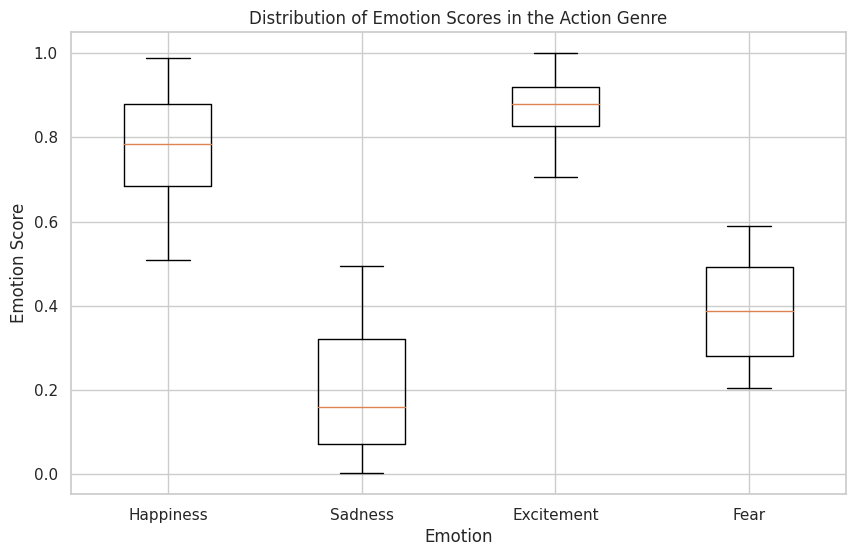

In [64]:
plt.figure(figsize=(10, 6))
plt.boxplot(emotions, labels=emotion_labels)
plt.title('Distribution of Emotion Scores in the Action Genre')
plt.ylabel('Emotion Score')
plt.xlabel('Emotion')
plt.grid(True)
plt.show()

#### Method 3: Time Series Analysis

Time series analysis involves the study of data points collected or recorded at specific time intervals. The goal is to identify meaningful statistics and characteristics of the data. Time series data can be decomposed into several components, typically including trend, seasonality, and noise.

##### Components of Time Series

1. *Trend (T_t)*: The long-term progression of the series. It represents the general direction in which the data is moving over a long period.
2. *Seasonality (S_t)*: The repeating short-term cycle in the series. It captures the periodic fluctuations.
3. *Noise (N_t)*: The random variation in the series. It represents the irregular fluctuations that do not follow a pattern.

Mathematically, a time series can be represented as:

$$Y_t = T_t + S_t + N_t$$

or in a multiplicative form:

$$Y_t = T_t \times S_t \times N_t$$

##### Mathematical Notation and How We Use It

We are going to perform time series analysis on emotion classification results from movie plots.

After conducting an emotion classification task on 40,000 movie plots, resulting in 8 different emotion classes, each with a respective probability for each plot. The goal is to analyze how these emotions have changed over the years.

The steps involved are:
1. Calculate the average probability of each emotion for each year.
2. Perform time series analysis on each emotion to observe trends and changes over time.
3. Model these time series using statistical methods.

Possible statistical models for time series analysis include:
- *ARIMA (AutoRegressive Integrated Moving Average)*
    Trying to model the next value in the series as a linear combination of the previous values and the previous errors.
    - Formula: ARIMA(p, d, q)
    - General form: $$\Delta^d Y_t = \phi_1 \Delta^d Y_{t-1} + \cdots + \phi_p \Delta^d Y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \cdots + \theta_q \epsilon_{t-q}$$

- *SARIMA (Seasonal AutoRegressive Integrated Moving Average)*
    Extends ARIMA to include seasonality.
    - Formula: SARIMA(p, d, q)(P, D, Q, s)
    - General form: $$\Delta^d Y_t = \phi_1 \Delta^d Y_{t-1} + \cdots + \phi_p \Delta^d Y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \cdots + \theta_q \epsilon_{t-q} + \text{seasonal terms}$$

- *Exponential Smoothing State Space Model (ETS)*
    A flexible model that can capture different types of trends and seasonaliy.
    - Formula: ETS(A, Ad, N)
    - General form: $$Y_t = (\text{level} + \text{trend} + \text{seasonality}) \times \text{error}$$

- *GARCH (Generalized Autoregressive Conditional Heteroskedasticity)*
    A model for analyzing and forecasting time series data that includes autoregressive and moving average terms for the variance.
    - Formula: GARCH(p, q)
    - General form: $$\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \cdots + \alpha_p \epsilon_{t-p}^2 + \beta_1 \sigma_{t-1}^2 + \cdots + \beta_q \sigma_{t-q}^2$$

These models will help us understand the temporal dynamics of emotions in movie plots and potentially forecast future trends. 

Just to give an example here is a setup where we generated a random series from an ARIMA(1,1,1) model.

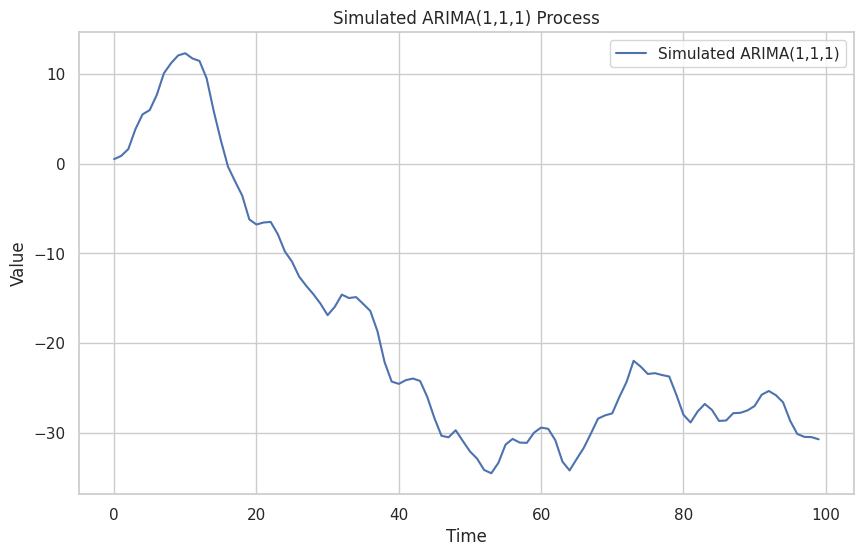

In [65]:
from statsmodels.tsa.arima_process import ArmaProcess

# Define the autoregressive and moving average coefficients
ar = np.array([1, -0.5])
ma = np.array([1, 0.5])
arma_process = ArmaProcess(ar, ma)

# Simulate an ARMA(1,1) prcess
np.random.seed(42)
simulated_data = arma_process.generate_sample(nsample=100)

# Integrate the data to get the ARIMA(1,1,1)
integrated_data = np.cumsum(simulated_data)

# Plot the integrated data to get the ARIMA(1,1,1)
plt.figure(figsize=(10, 6))
plt.plot(integrated_data, label='Simulated ARIMA(1,1,1)')
plt.title('Simulated ARIMA(1,1,1) Process')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

#### Method 4: Regression Analysis

##### Mathematical notation
The regression model to analyze the impact of emotions on actor traits (age and gender) and movie language can be expressed as follows:

$$
\begin{equation*}
	\begin{aligned}
    Y = \beta_0 + \beta_1 \times X_1 + \beta_2 \times X_2 + ... + \beta_n \times X_n  
    \end{aligned}
\end{equation*}
$$

Where: <br>
$\ Y$ is the Dependent Variable <br>
$\ X_i$ are the independent variables (the emotion score of emotion $i$ )<br>
$\beta_i$ are the coefficients for emotion $i$ <br>
$n$ is the number of emotions

Assumptions: <br>
Linear relationship between the dependent variable and each of the independent variable <br>
Independence of Variables


By analyzing the coefficient see the influence of each variable X_i on the dependent variable Y. The sign of the coefficient tells us if the influence is positive or negative. 

This regression forumlation would show the different impact of age, gender and languages on the emotion score of a given emotion, when computing the regression on the whole dataset: <br>
$$
\begin{equation*}
	\begin{aligned}
    Y = \beta_0 + \beta_1 \times \text{Age} + \beta_2 \times \text{Gender} + \beta_3 \times \text{Spanish} + \beta_4 \times \text{French} 
\end{aligned}
\end{equation*}
$$

When modelling age, gender and language as the dependend variable when need to take into account their variable type. While age is continuously and can be modelled with the expression obove, gender is a binary variable and language categorial. 

For the binary variable gender we use logistic regression:
$$
\begin{equation*}
	\begin{aligned}
        \log\left(\frac{P(Y = 1)}{P(Y = 0)}\right) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \ldots + \beta_nX_n
    \end{aligned}
\end{equation*}
$$


Where $Y = 1$ indicates female, and $Y = 0$ indicates male. The probability that $Y$ is female is given by:
$$
\begin{equation*}
	\begin{aligned}
        P(Y = 1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1X_1 + \beta_2X_2 + \ldots + \beta_nX_n)}}
    \end{aligned}
\end{equation*}
$$

To obtain the coefficients that fit best to the date linear regression typically uses ordinary least squares. Logistic regression can be solved with Maximum Likelihood Estimation.

Logistic Regression:  The objective is to maximize the log-likelihood   $\max_{\beta} \ell(\beta))$

Linear Regression: The objective is to minimize the cost Function $J(\beta)$ based on Ordinary Least Square $J\min_{\beta} J(\beta)$

#### Method 5: Clustering

To later explore the connection between emotional tones and user ratings, we first the cluster movies based on similarity of their emotional profiles. 
Patterns between clusters and user ratings are examined to determine how the different emotions influence user ratings and how the influence may vary across genres.

There are different clustering techniques to explore. Hierarchical methods enable the examination of similarity and dissimilarity across varying numbers of clusters. In contrast, non-hierarchical methods, such as k-means, focus on optimizing clustering for a predefined number of clusters.
##### Mathematical Notation

Given a set of $ n $ objects $ X = \{x_1, x_2, \ldots, x_n\} $, cluster analysis aims to partition these objects into $ k $ clusters $ C = \{C_1, C_2, \ldots, C_k\} $ such that:

1. $ \bigcup_{i=1}^{k} C_i = X $ (each object belongs to exactly one cluster)
2. $ C_i \cap C_j = \emptyset$ for $ i \neq j $ (clusters are mutually exclusive)

The similarity or dissimilarity between objects is often measured using a distance metric $ d(x_i, x_j) $. Common distance metrics include:

- Euclidean distance: $ d(x_i, x_j) = \sqrt{\sum_{m=1}^{p} (x_{im} - x_{jm})^2} $
- Manhattan distance: $ d(x_i, x_j) = \sum_{m=1}^{p} |x_{im} - x_{jm}| $
- Cosine similarity: $ d(x_i, x_j) = 1 - \frac{\sum_{m=1}^{p} x_{im} x_{jm}}{\sqrt{\sum_{m=1}^{p} x_{im}^2} \sqrt{\sum_{m=1}^{p} x_{jm}^2}} $


##### Clustering Algorithms to Explore

Several algorithms can be used for our cluster analysis, including:

1. *K-means clustering*: This algorithm partitions the data into $ k $ clusters by minimizing the within-cluster sum of squares (WCSS):
    $$
    \text{WCSS} = \sum_{i=1}^{k} \sum_{x \in C_i} \| x - \mu_i \|^2
    $$
    where $ \mu_i $ is the centroid of cluster $ C_i $.

2. *Hierarchical clustering*: This algorithm builds a hierarchy of clusters either by agglomerative (bottom-up) or divisive (top-down) approaches. The result is often visualized using a dendrogram.

3. *DBSCAN (Density-Based Spatial Clustering of Applications with Noise)*: This algorithm groups together points that are closely packed together, marking points that are in low-density regions as outliers.

4. *Gaussian Mixture Models (GMM)*: This algorithm assumes that the data is generated from a mixture of several Gaussian distributions with unknown parameters. It uses the Expectation-Maximization (EM) algorithm to estimate the parameters.

##### Example use for K-Means

We plan to cluster the movies based on its emotional profile. To create a similarity measure we take the L1 (L2 norm would square, which is not good with probabilities (values below 0)) of the 8 emotion score of each movie. We than calculate the distance between two movies based on one of the distance measure above. Different initializations help prevent bad results because of 

The movie clusters can further be analyzed on its relationship towards movie ratings. One idea would be to calculate the average rating of the movies within a cluster and analyze if there are notable differences.

##### Evaluation Metrics

To evaluate the quality of clustering, several metrics can be used, including:

- *Silhouette score*: Measures how similar an object is to its own cluster compared to other clusters.
  $$
  s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
  $$
  where $ a(i) $ is the average distance between $ i $ and all other points in the same cluster, and $ b(i) $ is the minimum average distance between $ i $ and points in a different cluster.

- *Davies-Bouldin index*: Measures the average similarity ratio of each cluster with its most similar cluster.
  $$
  DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{\sigma_i + \sigma_j}{d(\mu_i, \mu_j)} \right)
  $$
  where $ \sigma_i$ is the average distance between each point in cluster $i$ and the centroid $\mu_i $, and $ d(\mu_i, \mu_j) $ is the distance between centroids $ \mu_i $ and $ \mu_j $.